### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

# from utils import *
from matplotlib import rcParams

from re import sub
from decimal import Decimal
from datetime import datetime
from sklearn.cluster import KMeans 


from scipy.stats import iqr
from scipy.stats import expon, kstest, norm, exponnorm, gamma, beta, loggamma, lognorm, t, chi2, gengamma, uniform
from statsmodels.distributions import ECDF


import plotly.express as px
from sklearn.model_selection import train_test_split


rcParams['figure.figsize'] = 20,7
sns.set_theme(style="darkgrid")
sns.set(font_scale=1.5)


### Help functions

In [2]:
def series_random_split_on2(series):
    part_50 = series.sample(frac = 0.5)
    rest_part_50 = series.drop(part_50.index)
    return part_50, rest_part_50

def array_random_split_on2(arr):
    arr = np.array(arr)
    return train_test_split(arr, test_size=0.5, shuffle=True, random_state=42)

In [3]:
def plot_hist(data):
    sns.distplot(data, hist=True, kde=True, kde_kws={"shade": True})
    plt.show()

In [4]:
def plot_pair(data, dist_cdf, dist_pdf, distribution_name, title, ymax_hist=None, bins=None):
    x = np.linspace(min(data), max(data), num=100000)
    ecdf = ECDF(data)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))
    axes[0].step(ecdf.x, ecdf.y, label="Data ECDF")
    axes[0].plot(x, dist_cdf(x), color="r", linestyle="--", label="CDF" if distribution_name is None else f"{distribution_name} CDF")
    axes[0].set_xlabel('x')
    axes[0].tick_params(axis='x', labelrotation=45)
    axes[0].set_ylabel('CDF')
    axes[0].legend()
    bins = int((2*len(data)) ** (1 / 2.5)) if len(data)*2 < 10000 else int((2*len(data)) ** (1 / 3.0)) if bins is None else bins
    axes[1].hist(data, density=True, bins=bins, alpha=0.5, label='Data hist')
    axes[1].plot(x, dist_pdf(x), 'r', label="PDF" if distribution_name is None else f"{distribution_name} PDF")
    axes[1].legend()
    if ymax_hist:
        axes[1].axis(ymax=ymax_hist)
    axes[1].set_xlabel("x")
    axes[1].tick_params(axis='x', labelrotation=45)
    axes[1].set_ylabel("density")
    # plt.suptitle('Amazing Stats', size=16, y=1.12);      
    plt.xticks(rotation=45)
    fig.suptitle(title, y=1.07)
    plt.show()



def run_kstest(data, distribution, distribution_name=None, title="DisbursementGross", ymax_hist=None, bins=None):

    # Split data on 2 fractions
    data1, data2 = array_random_split_on2(data)

    # Fit on data1
    MLE_args = distribution.fit(data1)

    dist_cdf = lambda x: distribution.cdf(x, *MLE_args)
    dist_pdf = lambda x: distribution.pdf(x, *MLE_args)    
    

    # Test hypothesis on data2
    hypothesis = lambda x: distribution.cdf(x, *MLE_args)
    res = kstest(data2, hypothesis)
    plot_pair(data2, 
              dist_cdf=dist_cdf,
              dist_pdf=dist_pdf,
              distribution_name=distribution_name,
              ymax_hist=ymax_hist,
              bins=bins,
              title=title + f"\nKstestResult(statistic={res.statistic:0.2f}, pvalue={res.pvalue})")


### Load data and prepare dataframes

In [5]:
df = pd.read_csv("SBAnational.csv")

df.drop("ChgOffDate", axis=1, inplace=True)
df.drop("LoanNr_ChkDgt", axis=1, inplace=True)
df.drop("City", axis=1, inplace=True)
df.drop("Zip", axis=1, inplace=True)
df.drop("Bank", axis=1, inplace=True)
df.drop("BankState", axis=1, inplace=True)
df.drop("ApprovalDate", axis=1, inplace=True)
df.drop("ApprovalFY", axis=1, inplace=True)
df.drop("FranchiseCode", axis=1, inplace=True)
# df.drop("DisbursementDate", axis=1, inplace=True)
df.drop("BalanceGross", axis=1, inplace=True)
df.drop("Name", axis=1, inplace=True)
df.drop("ChgOffPrinGr", axis=1, inplace=True)
df.drop("GrAppv", axis=1, inplace=True)
df.drop("SBA_Appv", axis=1, inplace=True)

df.dropna(inplace=True)

In [6]:
currency_cols = ["DisbursementGross"]
for currency_col in currency_cols:
    df[currency_col] = (
        df[currency_col]
        .apply(lambda x: Decimal(sub(r"[^\d.]", "", x)))
        .astype("float32")
    )
df = df[(df.RevLineCr == "Y") | (df.RevLineCr == "N")]
df = df[(df.LowDoc == "Y") | (df.LowDoc == "N")]
df["Default"] = df["MIS_Status"].apply(lambda x: 1 if x == "CHGOFF" else 0)
df.NAICS = df.NAICS.apply(lambda x: "NaN" if x == 0 else str(x)[:2])
df.drop("MIS_Status", axis=1, inplace=True)

df["DisbursementDate"] = df["DisbursementDate"].apply(
    lambda date_str: datetime.strptime(date_str, "%d-%b-%y")
)

df['DisbursementYr'] = df['DisbursementDate'].apply(lambda x: x.year)
df['DisbursementMo'] = df['DisbursementDate'].apply(lambda x: x.month)
df['RevLineCr'] = df['RevLineCr'].apply(lambda x: 1 if x == 'Y' else 0)
df['LowDoc'] = df['LowDoc'].apply(lambda x: 1 if x == 'Y' else 0)
df['NewBusiness'] = df['NewExist'].apply(lambda x: 1 if x == 2 else 0)
df.drop("NewExist", axis=1, inplace=True)
# df = df[~(df['UrbanRural'] == "NaN")]
# df['Urban'] = df['UrbanRural'].apply(lambda x: 1 if x == 1 else 0)
df.drop("UrbanRural", axis=1, inplace=True)
# df = df[~(df['NAICS'] == "NaN")]


In [7]:
NUMERICAL_COLS = ["Term", "NoEmp", "DisbursementYr", "DisbursementGross", 
                  "CreateJob", "RetainedJob", ]
CATEGORICAL_COLS = ["DisbursementMo", "State", "NAICS", "UrbanRural"] 
BINARY_COLS = ["NewBusiness", "LowDoc", "RevLineCr", "Default"]  
DATE_COLS = ["DisbursementDate"]
ALL_COLS = list(df.columns)

### Remove large outliers DisbursementGross

<AxesSubplot: >

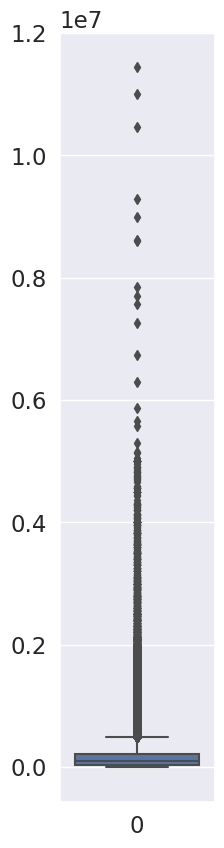

In [8]:
plt.figure(figsize=(2, 10))
sns.boxplot(df['DisbursementGross'], )

In [9]:
df_iqr = iqr(df['DisbursementGross'])
df_min, df_max = df['DisbursementGross'].median() - 1.5*df_iqr, df['DisbursementGross'].median() + 1.5*df_iqr 
df = df[(df['DisbursementGross'] < df_max) & (df['DisbursementGross'] > df_min)]

<AxesSubplot: >

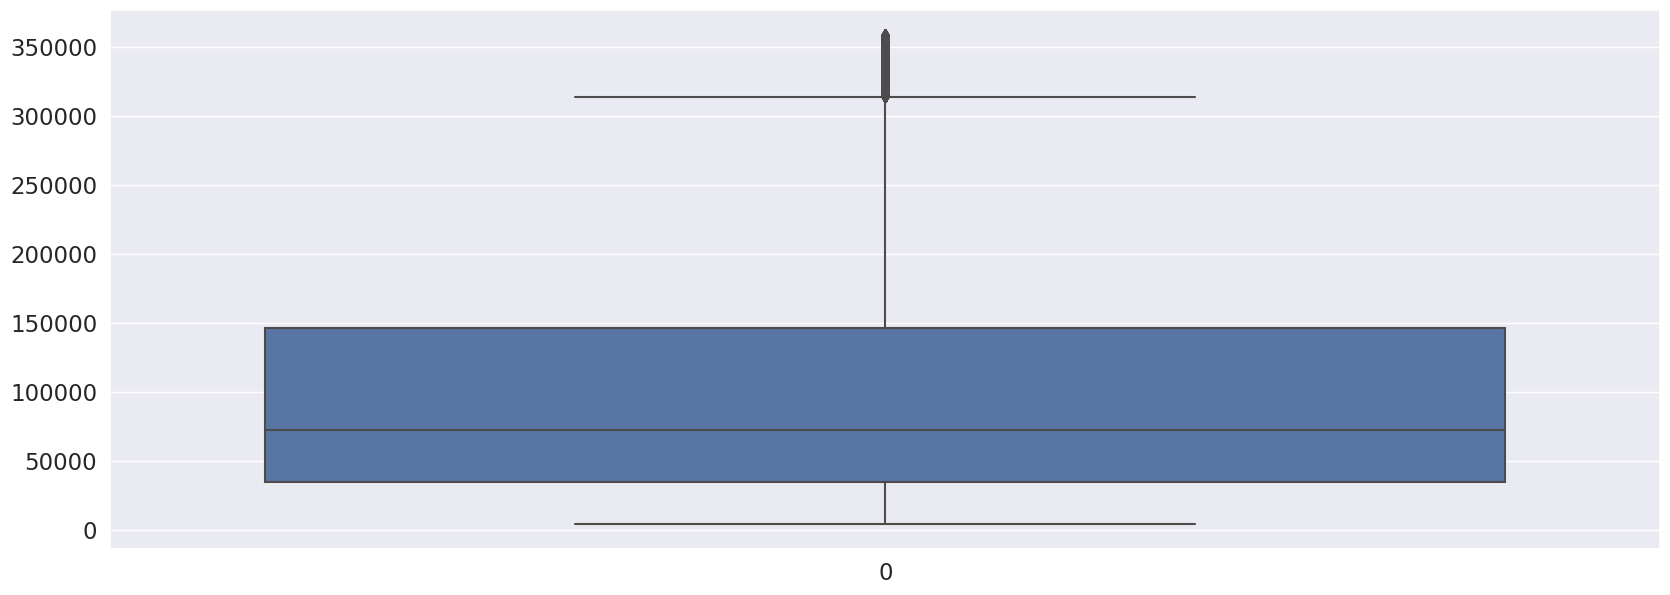

In [10]:
sns.boxplot(df['DisbursementGross'])

### Remove large outliers DisbursementYr


<AxesSubplot: >

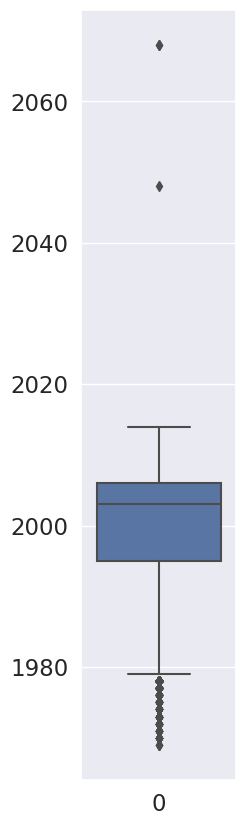

In [11]:
plt.figure(figsize=(2, 10))
sns.boxplot(df['DisbursementYr'])

In [12]:
df = df[df['DisbursementYr'] < 2020]

### Aggregate dateset

In [13]:
def avg_column(x):
    if "Yr" in x or "Date" in x:
        return x
    return "Средний " + x

def perc_column(x):
    if "Yr" in x or "Date" in x:
        return x
    return "Процент " + x


# data_month = df.resample('M', on='ApprovalDate').mean()
df_avg_M = df.groupby(pd.PeriodIndex(df['DisbursementDate'], freq="M"))[NUMERICAL_COLS].mean().reset_index()
df_perc_M = df.groupby(pd.PeriodIndex(df['DisbursementDate'], freq="M"))[BINARY_COLS].mean().reset_index()

df_avg_M.columns = df_avg_M.columns.to_series().apply(avg_column)
df_perc_M.columns = df_perc_M.columns.to_series().apply(perc_column)


df_agg_M = pd.merge(left=df_avg_M, right=df_perc_M)
df_agg_M['DisbursementMonthlyDate'] = df_agg_M['DisbursementDate'].apply(lambda x: datetime.strptime(str(x), '%Y-%m'))
df_agg_M

DisbursementDate  Средний Term  Средний NoEmp  DisbursementYr  \
0            1969-05    171.000000       5.500000          1969.0   
1            1969-10     84.000000      34.000000          1969.0   
2            1970-02    240.000000      11.500000          1970.0   
3            1970-04     60.000000      11.000000          1970.0   
4            1970-05    421.000000       4.000000          1970.0   
..               ...           ...            ...             ...   
528          2014-04     62.318182       6.772727          2014.0   
529          2014-05     71.631579      11.000000          2014.0   
530          2014-06     53.750000       7.750000          2014.0   
531          2014-07     72.000000     143.000000          2014.0   
532          2014-12     71.000000       3.000000          2014.0   

     Средний DisbursementGross  Средний CreateJob  Средний RetainedJob  \
0                113600.000000           0.000000             0.000000   
1                150000.000000           0.000000             0.000000   
2                 76250.000000           0.000000             0.000000   
3                 74952.000000           0.000000             0.000000   
4                 15000.000000           0.000000             0.000000   
..                         ...                ...                  ...   
528               82182.500000           0.863636             5.681818   
529               79313.156250           1.210526             8.526316   
530               82691.664062           1.666667             4.916667   
531               60000.000000           0.000000           143.000000   
532              140800.000000           1.000000             3.000000   

     Процент NewBusiness  Процент LowDoc  Процент RevLineCr  Процент Default  \
0               0.500000             0.0           0.000000              0.5   
1               0.000000             0.0           0.000000              1.0   
2               0.000000             0.0           0.000000              1.0   
3               0.000000             0.0           0.000000              1.0   
4               0.000000             0.0           0.000000              1.0   
..                   ...             ...                ...              ...   
528             0.227273             0.0           0.636364              0.0   
529             0.157895             0.0           0.736842              0.0   
530             0.500000             0.0           0.166667              0.0   
531             0.500000             0.0           1.000000              0.0   
532             0.000000             0.0           0.000000              0.0   

    DisbursementMonthlyDate  
0                1969-05-01  
1                1969-10-01  
2                1970-02-01  
3                1970-04-01  
4                1970-05-01  
..                      ...  
528              2014-04-01  
529              2014-05-01  
530              2014-06-01  
531              2014-07-01  
532              2014-12-01  

[533 rows x 12 columns]

### Clusters for original df

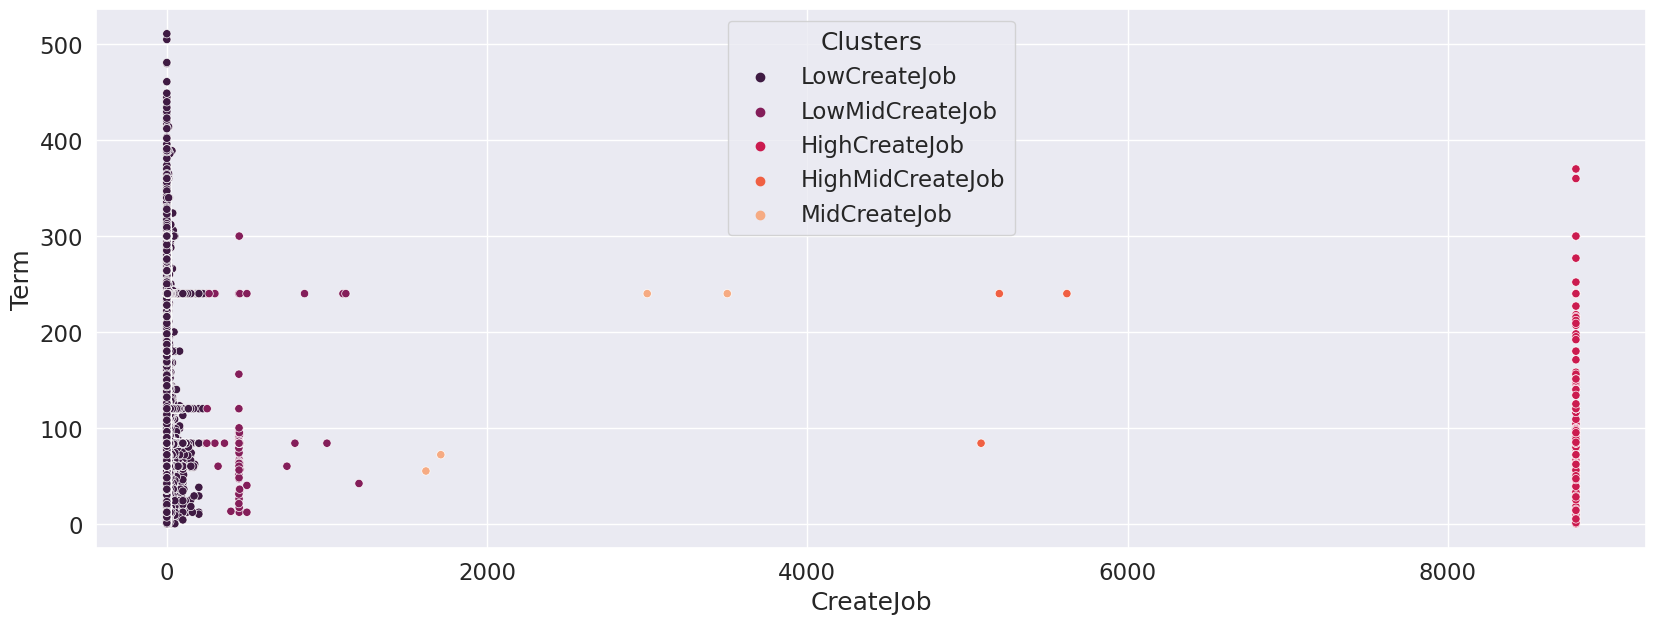

In [14]:
def cluster_unlabeling(x):
    
    target_clusters = ["LowCreateJob", "LowMidCreateJob", "MidCreateJob", "HighMidCreateJob", "HighCreateJob"]
    for i, elem in enumerate(clusters):
        if elem[1] == x:
            return target_clusters[i]

kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(df[['CreateJob']])
df['Clusters'] = kmeans.labels_
clusters = sorted([(df[df['Clusters'] == 0]['CreateJob'].mean(), 0),
            (df[df['Clusters'] == 1]['CreateJob'].mean(), 1),
            (df[df['Clusters'] == 2]['CreateJob'].mean(), 2),
            (df[df['Clusters'] == 3]['CreateJob'].mean(), 3),
            (df[df['Clusters'] == 4]['CreateJob'].mean(), 4)], 
            key=lambda u: u[0])
df['Clusters'] = df['Clusters'].apply(cluster_unlabeling)
sns.scatterplot(data=df, x="CreateJob", y="Term", hue = "Clusters", alpha=1, palette="rocket")
plt.show()

In [15]:
df['Clusters'].value_counts()

LowCreateJob        524477
HighCreateJob          534
LowMidCreateJob        103
MidCreateJob             4
HighMidCreateJob         3
Name: Clusters, dtype: int64

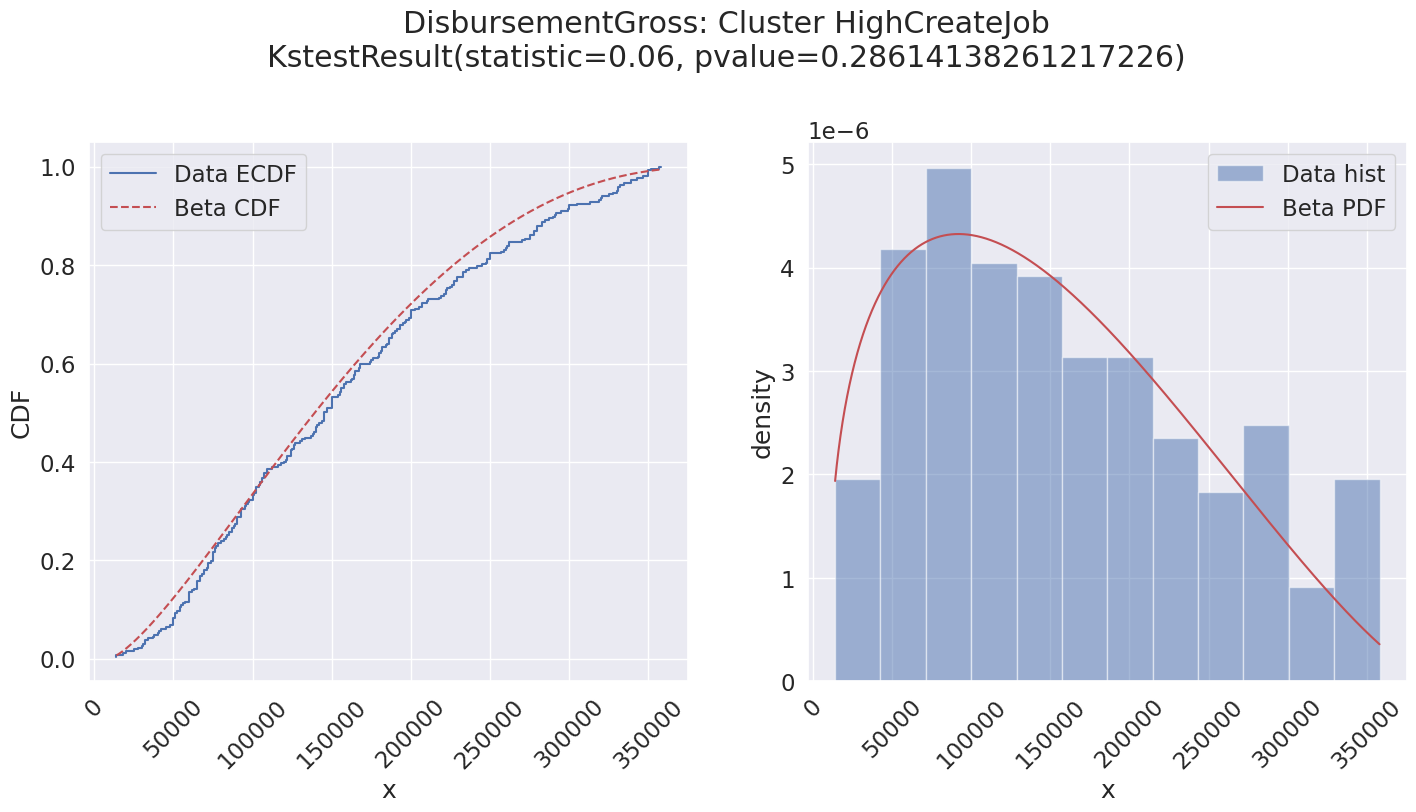

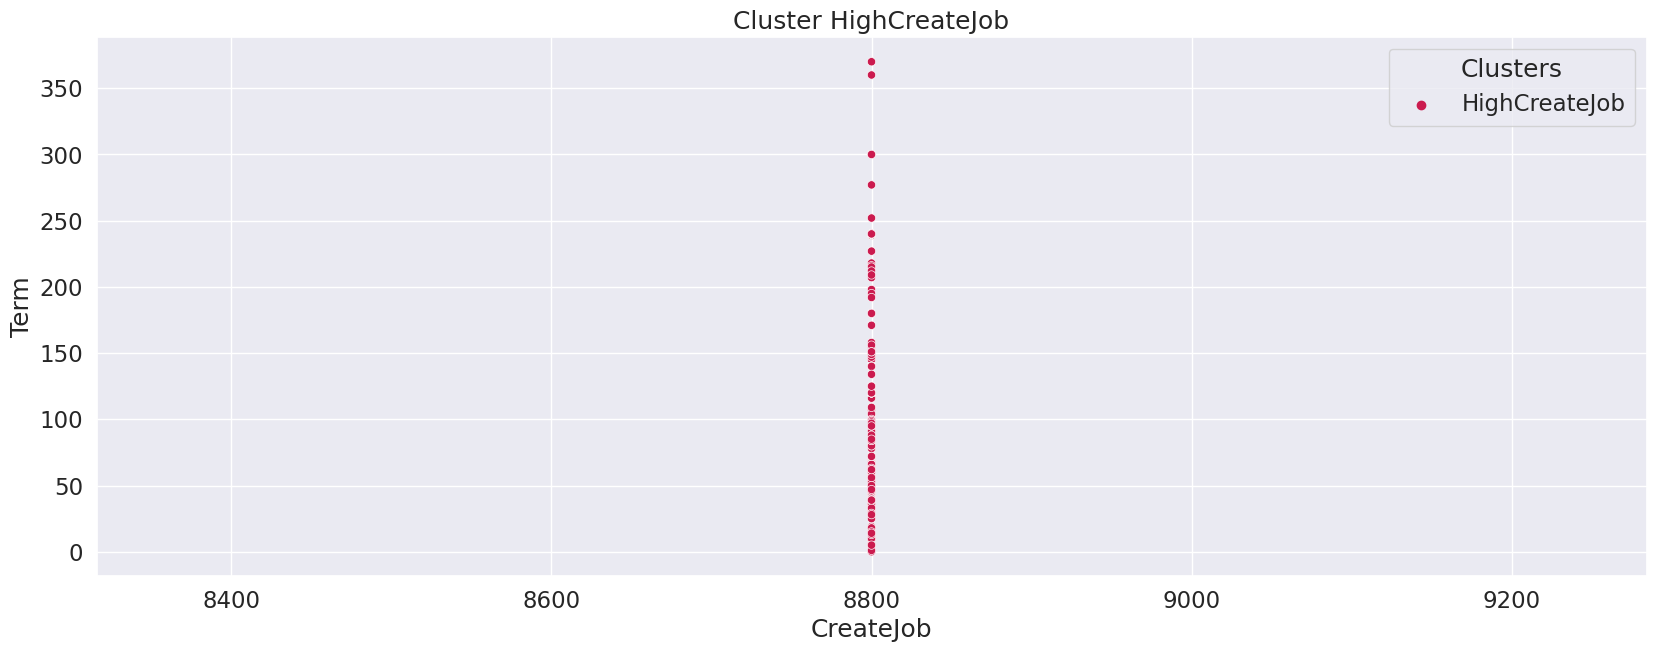

In [16]:
run_kstest(df[df['Clusters'] == "HighCreateJob"]['DisbursementGross'], 
           distribution=beta, 
           distribution_name="Beta",
           title="DisbursementGross: Cluster HighCreateJob")
plt.title("Cluster HighCreateJob")
sns.scatterplot(data=df[df['Clusters'] == "HighCreateJob"], x="CreateJob", y="Term", hue = "Clusters", palette="rocket")
plt.show()

In [17]:
# df['GrossCluster'] = df['DisbursementGross'].apply(lambda x: "DisbursementGross < 220k" if x < 0.22e7 else "DisbursementGross > 220k")
# plt.axvline(0.22e7, color='red')
# sns.scatterplot(data=df, x='DisbursementGross', y='Default', hue='GrossCluster', palette="rocket")




In [18]:
# plot_hist(df[df['GrossCluster'] == "DisbursementGross > 220k"].DisbursementYr)

In [19]:
# plot_hist(df[df['GrossCluster'] == "DisbursementGross < 220k"].DisbursementYr)

In [20]:
# run_kstest(df[df['GrossCluster'] == "DisbursementGross > 220k"]['DisbursementGross'],
#            expon)

In [21]:
# run_kstest(df[df['GrossCluster'] == "DisbursementGross < 220k"]['DisbursementGross'],
#            expon)

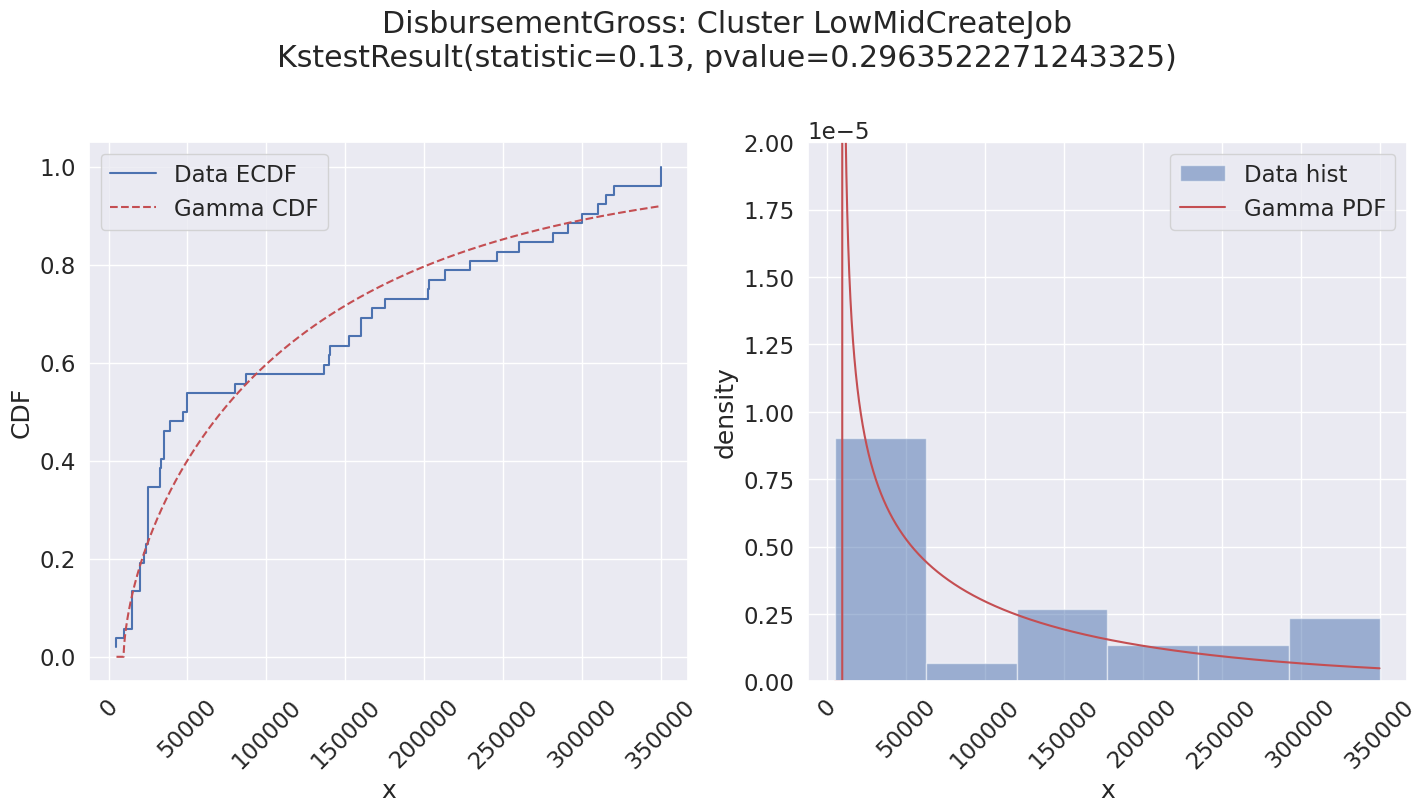

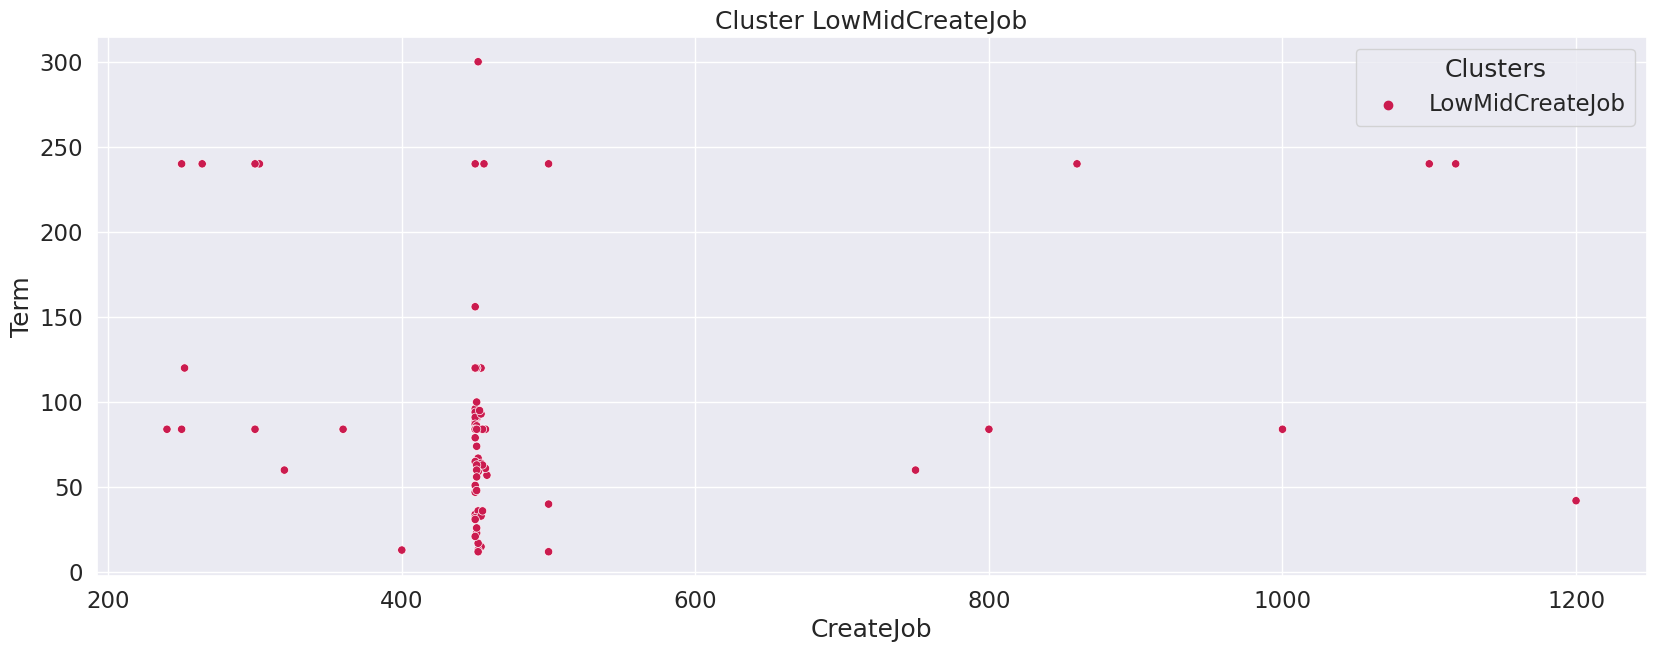

In [22]:
run_kstest(df[df['Clusters'] == "LowMidCreateJob"]['DisbursementGross'], 
           distribution=gamma, 
           distribution_name="Gamma",
           title="DisbursementGross: Cluster LowMidCreateJob",
           ymax_hist = 0.00002,
           bins=100)

plt.title("Cluster LowMidCreateJob")
sns.scatterplot(data=df[df['Clusters'] == "LowMidCreateJob"], x="CreateJob", y="Term", hue = "Clusters", palette="rocket")
plt.show()

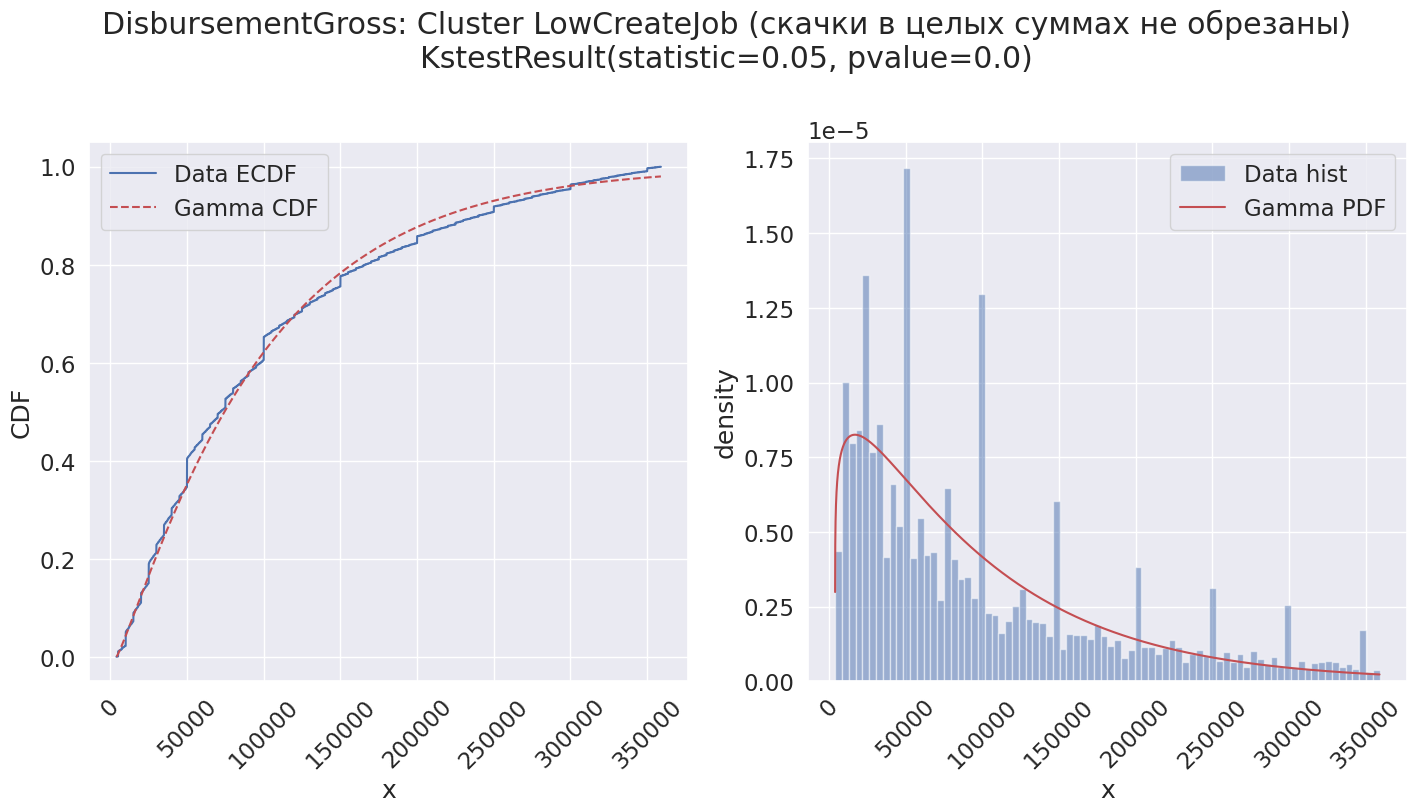

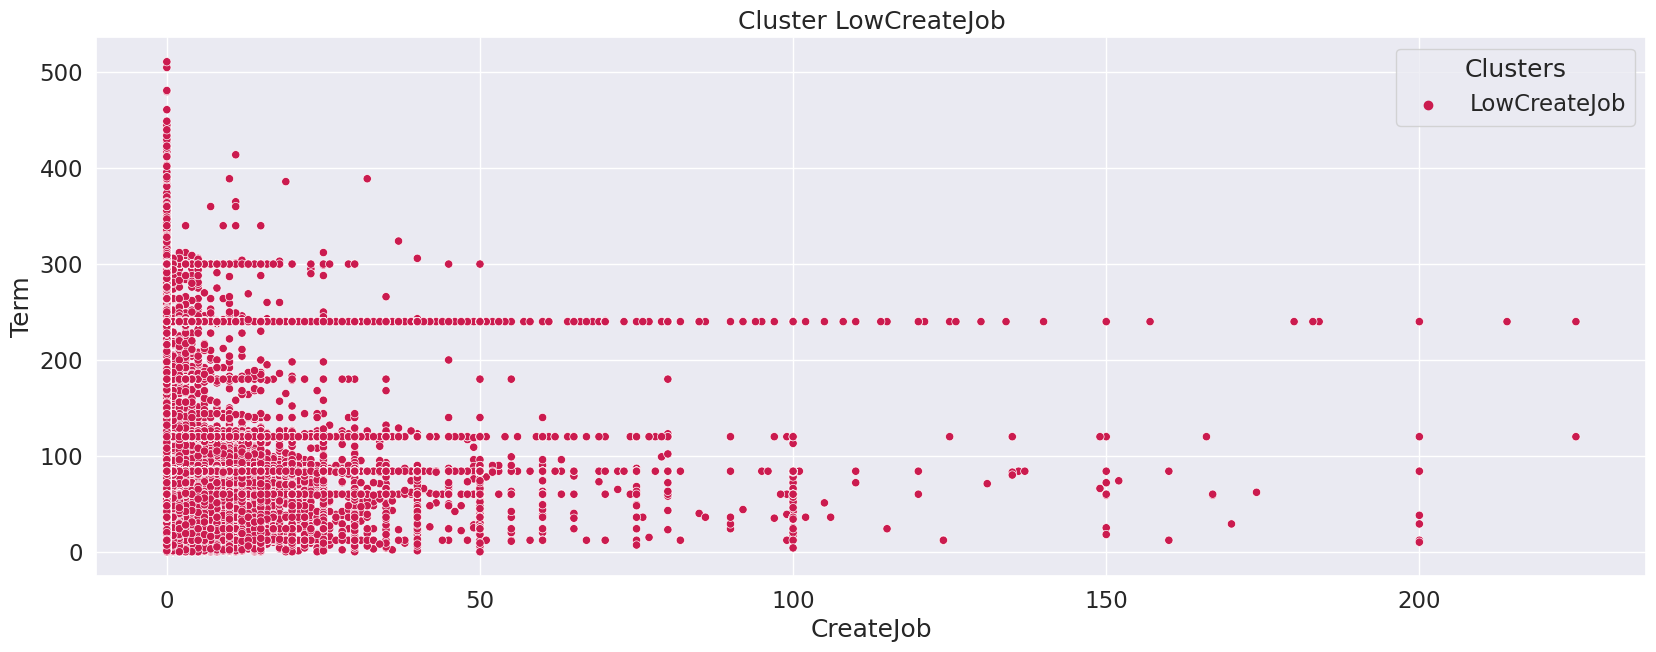

In [23]:
run_kstest(df[(df['Clusters'] == "LowCreateJob")]['DisbursementGross'], 
           distribution=gamma, 
           distribution_name="Gamma",
           title="DisbursementGross: Cluster LowCreateJob (скачки в целых суммах не обрезаны)")
plt.title("Cluster LowCreateJob")
sns.scatterplot(data=df[df['Clusters'] == "LowCreateJob"], x="CreateJob", y="Term", hue = "Clusters", alpha=1, palette="rocket")
plt.show()

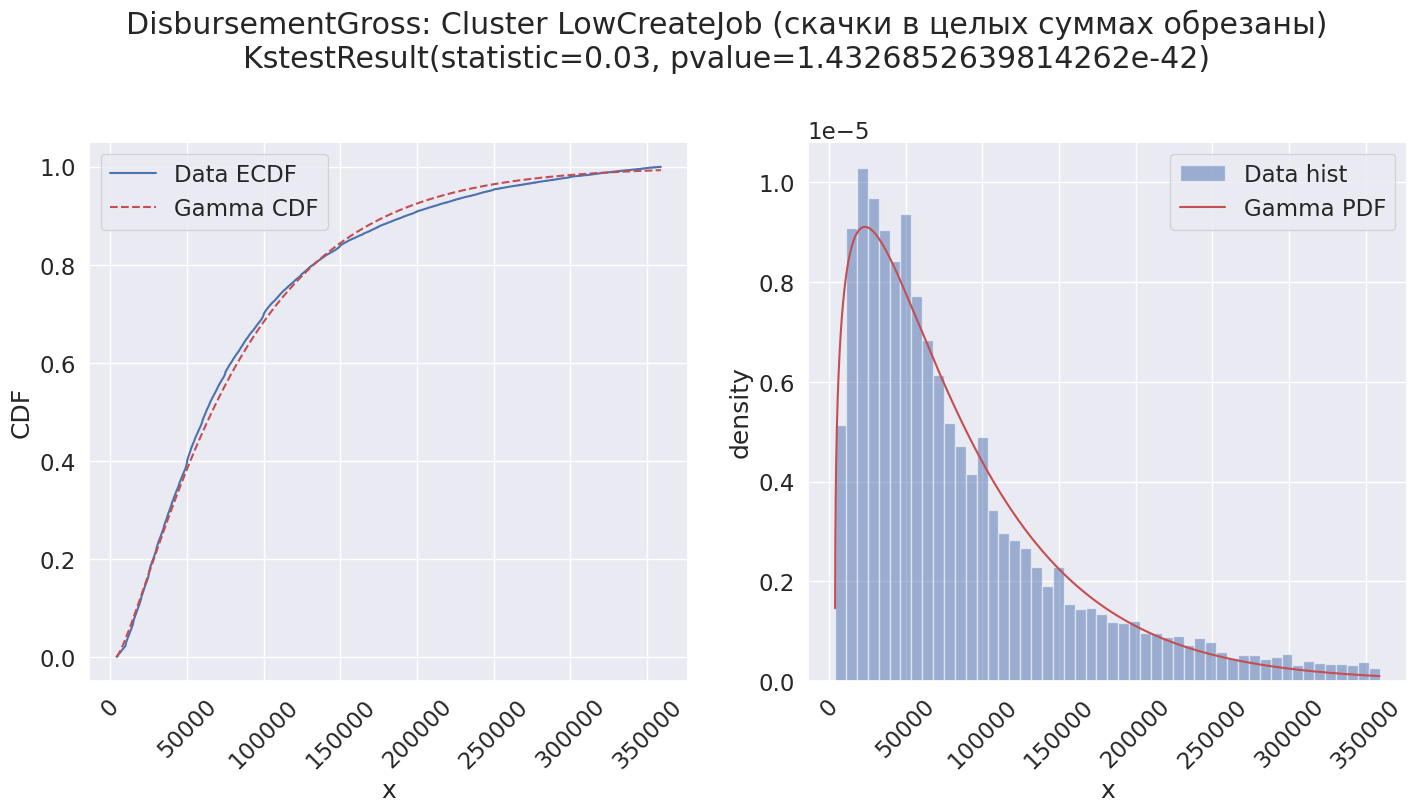

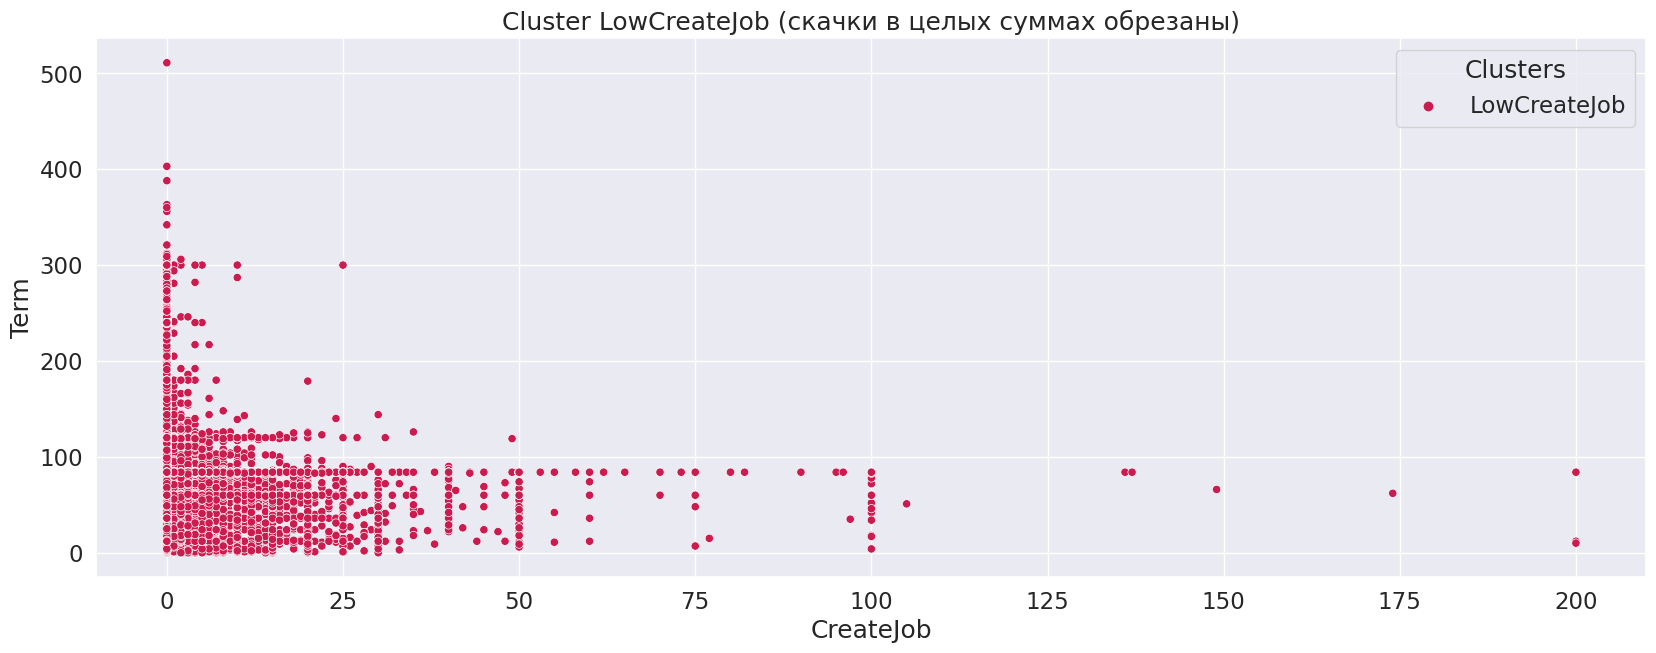

In [24]:
run_kstest(df[(df['Clusters'] == "LowCreateJob") & (df['DisbursementGross'] % 100 != 0)]['DisbursementGross'], 
           distribution=gamma, 
           distribution_name="Gamma",
           title="DisbursementGross: Cluster LowCreateJob (скачки в целых суммах обрезаны)")
plt.title("Cluster LowCreateJob (скачки в целых суммах обрезаны)")
sns.scatterplot(data=df[(df['Clusters'] == "LowCreateJob") & (df['DisbursementGross'] % 100 != 0)], x="CreateJob", y="Term", hue = "Clusters", alpha=1, palette="rocket")
plt.show()

### Clusters for aggregated df

In [25]:
def get_color(yr):
    if 1982 <= yr < 1990:
        return "1982 <= DisbursementYr < 1990"
    elif yr < 1982:
        return "DisbursementYr < 1982"
    elif 1990 <= yr:
        return "DisbursementYr >= 1990"
    # else:
        # return "DisbursementYr > 1990"

df_agg_M['Cluster'] = df_agg_M['DisbursementYr'].apply(get_color)

In [26]:
fig = px.scatter_3d(df_agg_M, x='Средний DisbursementGross', y='DisbursementMonthlyDate', z='Процент Default', color='Cluster', opacity=1)
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000,)
fig.show()

In [27]:
df_agg_M['Cluster'].value_counts()

DisbursementYr >= 1990           296
DisbursementYr < 1982            141
1982 <= DisbursementYr < 1990     96
Name: Cluster, dtype: int64

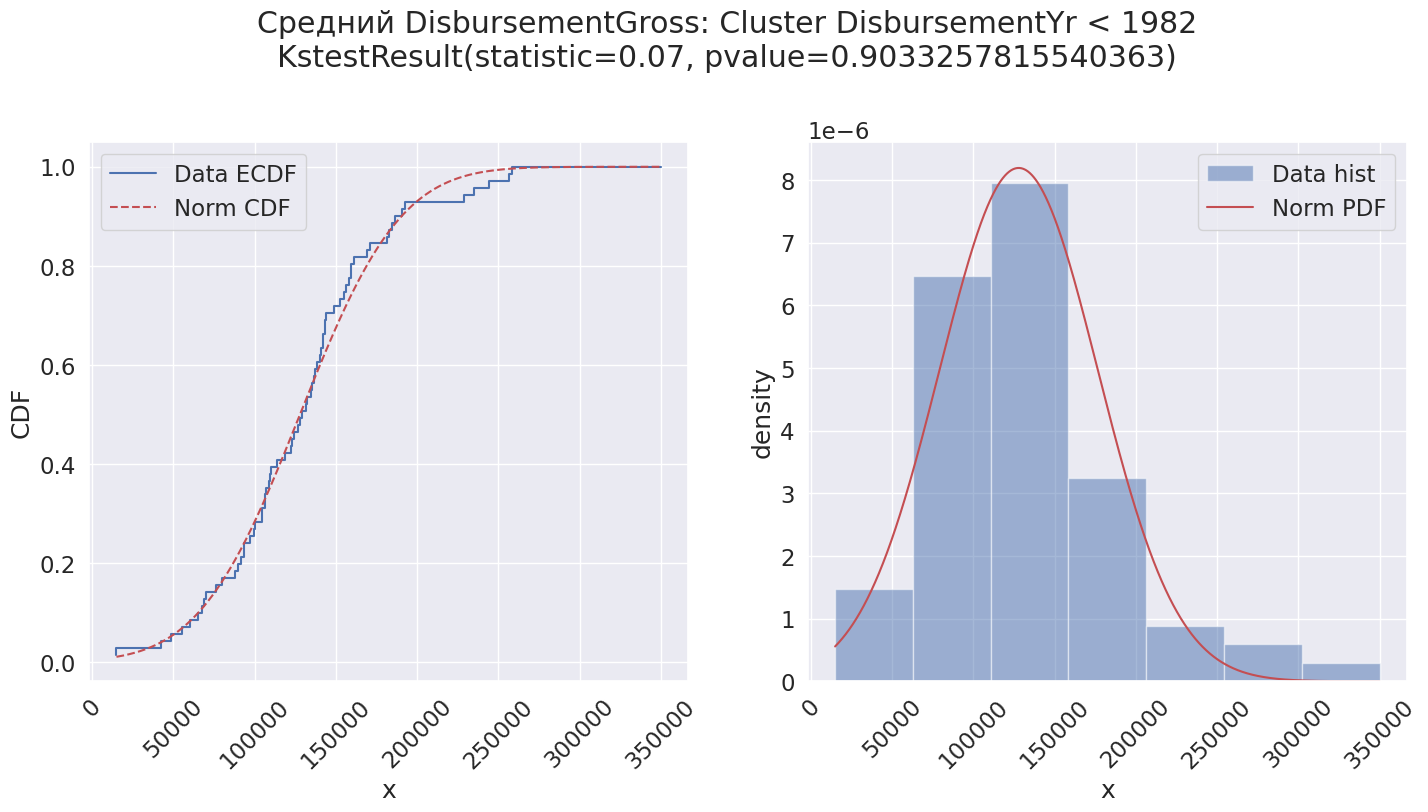

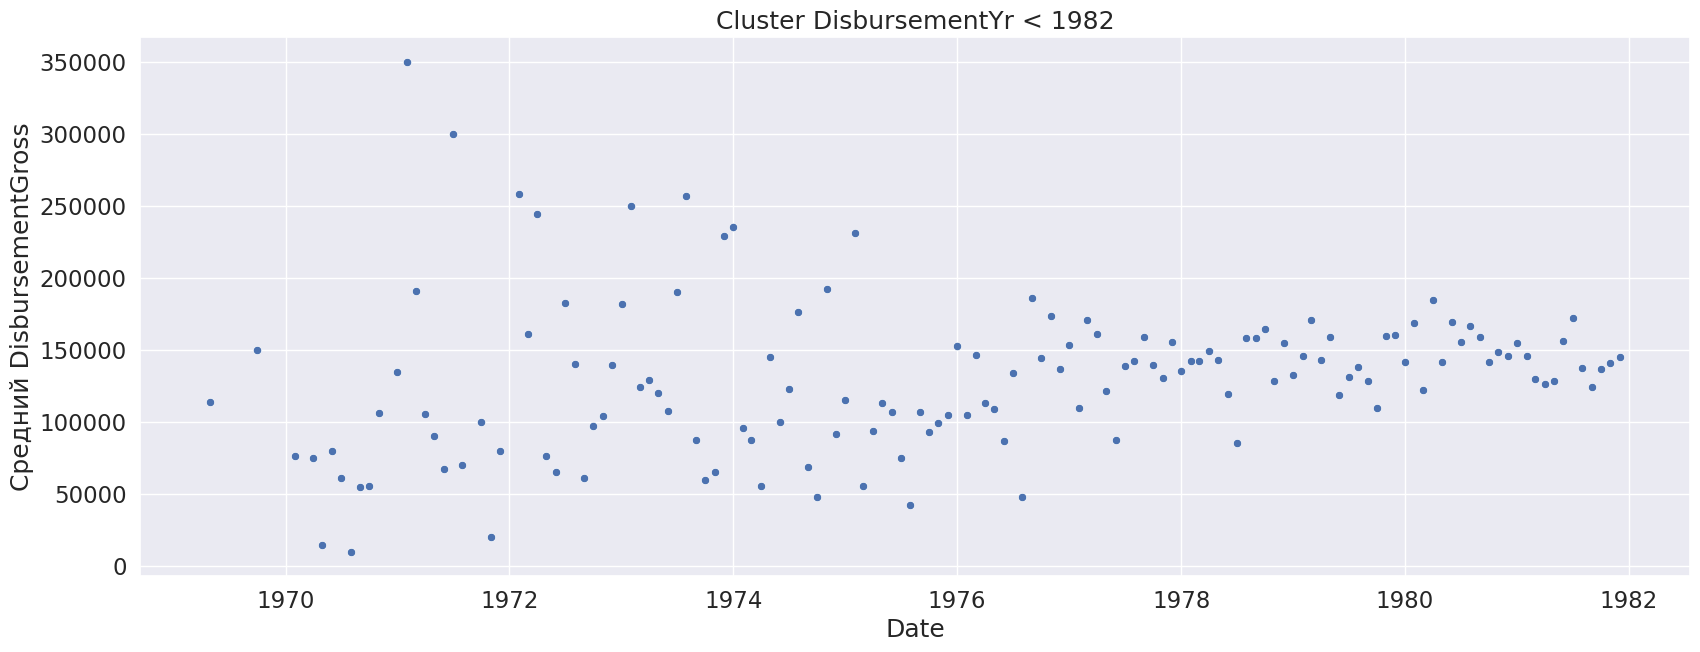

In [28]:
run_kstest(df_agg_M[(df_agg_M['Cluster'] == "DisbursementYr < 1982")]['Средний DisbursementGross'], 
           distribution=norm, 
           distribution_name="Norm",
           title="Средний DisbursementGross: Cluster DisbursementYr < 1982")

plt.title("Cluster DisbursementYr < 1982")
sns.scatterplot(data=df_agg_M[(df_agg_M['Cluster'] == "DisbursementYr < 1982")], x="DisbursementMonthlyDate", y="Средний DisbursementGross", alpha=1, palette="rocket")
plt.xlabel("Date")
plt.show()

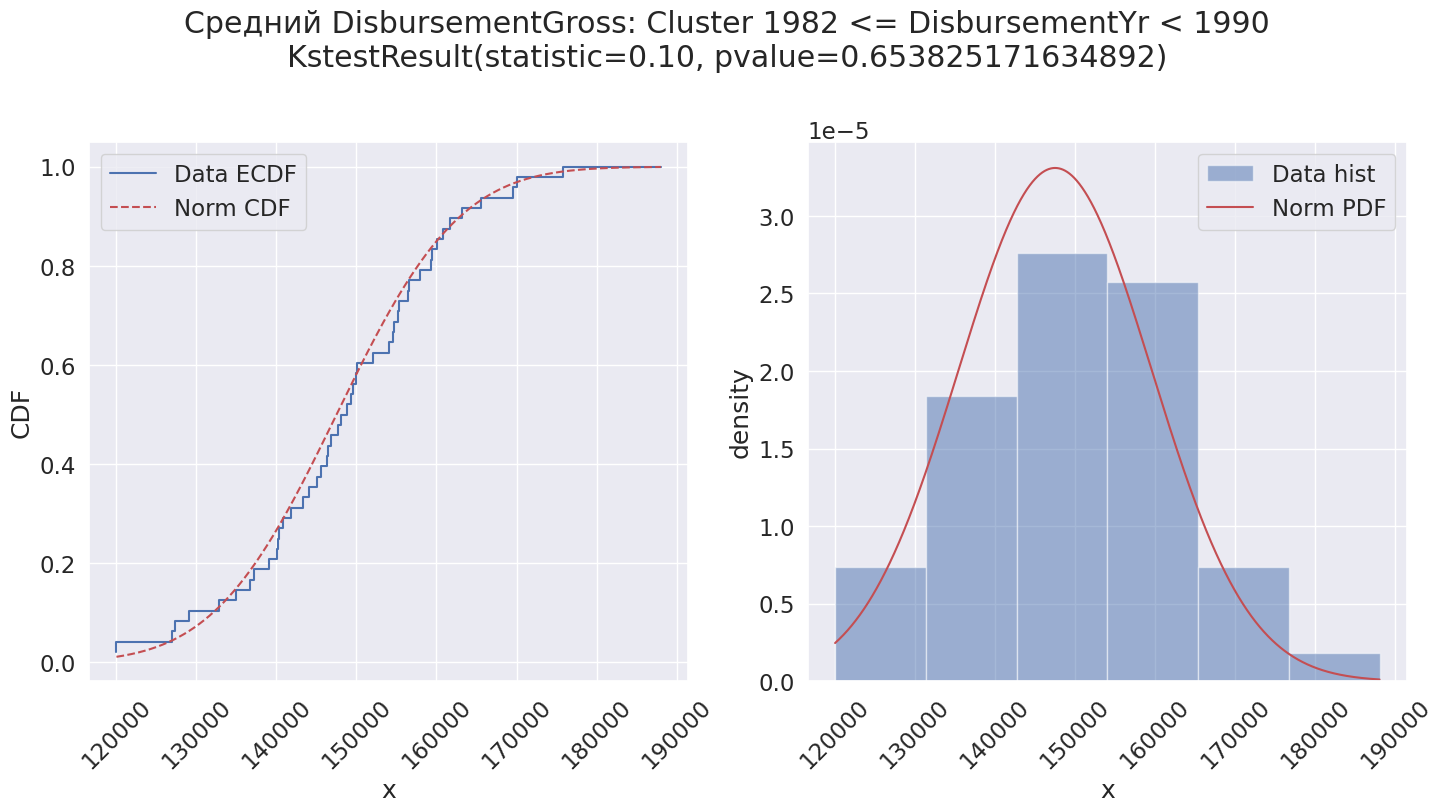

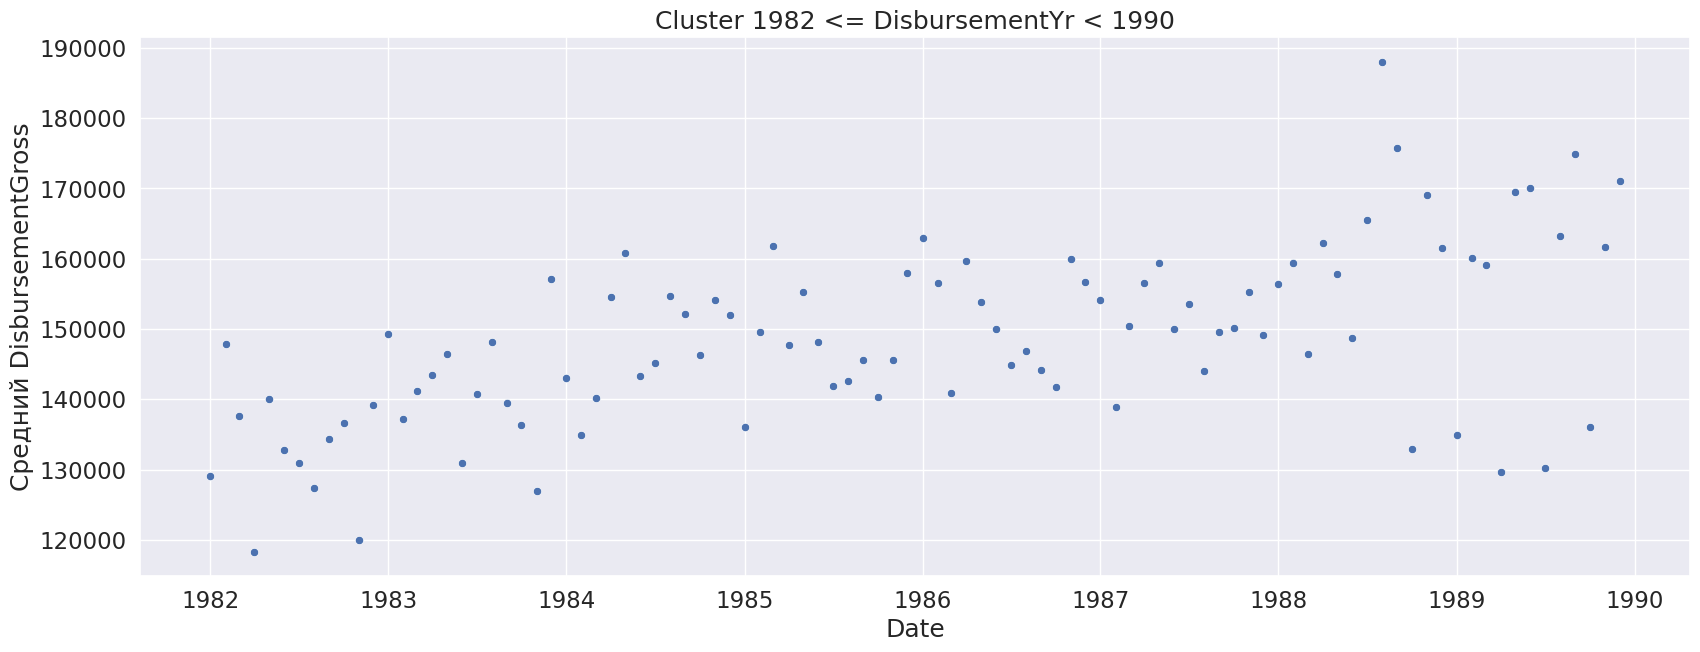

In [29]:
run_kstest(df_agg_M[(df_agg_M['Cluster'] == "1982 <= DisbursementYr < 1990")]['Средний DisbursementGross'], 
           distribution=norm, 
           distribution_name="Norm",
           title="Средний DisbursementGross: Cluster 1982 <= DisbursementYr < 1990")

plt.title("Cluster 1982 <= DisbursementYr < 1990")
sns.scatterplot(data=df_agg_M[(df_agg_M['Cluster'] == "1982 <= DisbursementYr < 1990")], x="DisbursementMonthlyDate", y="Средний DisbursementGross", alpha=1, palette="rocket")
plt.xlabel("Date")
plt.show()


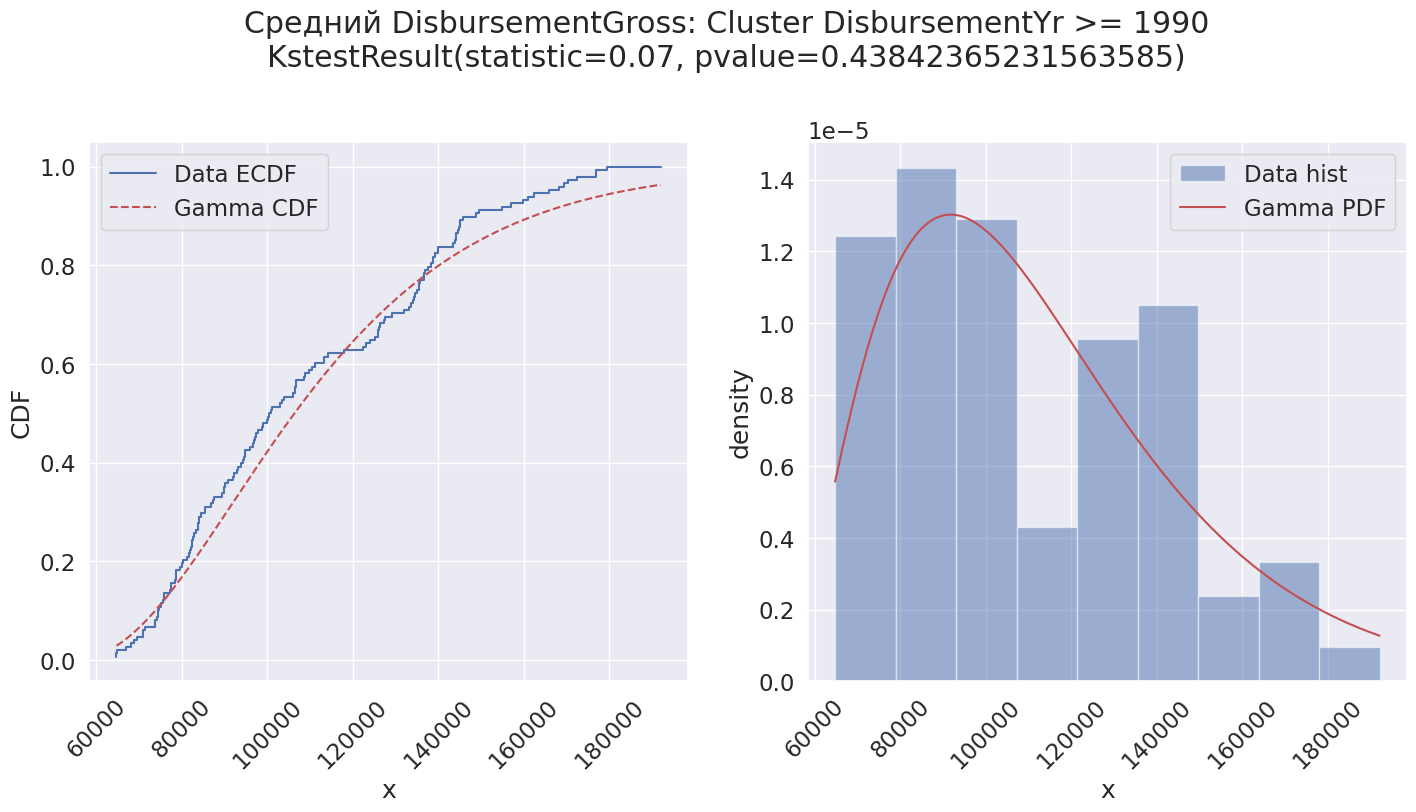

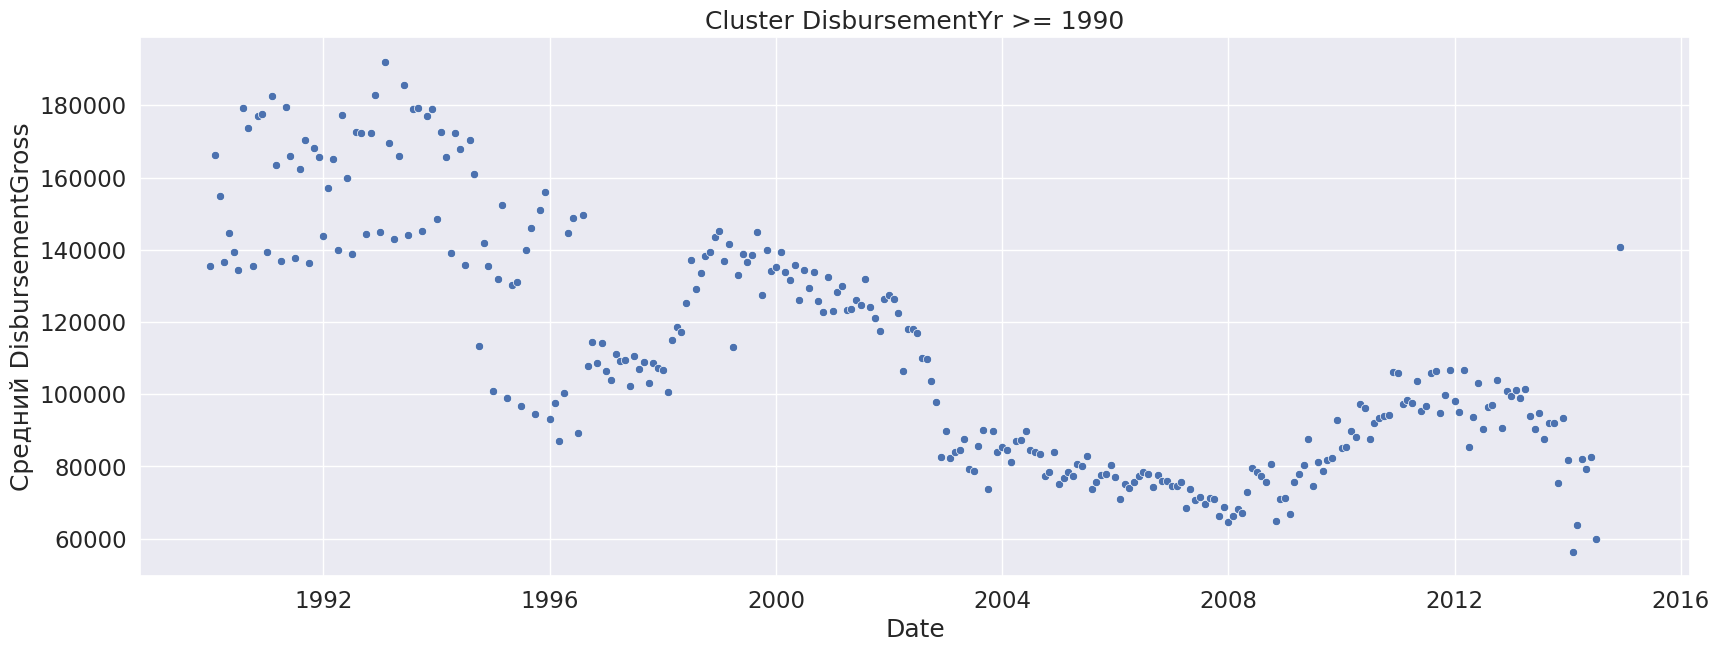

In [30]:
run_kstest(df_agg_M[(df_agg_M['Cluster'] == "DisbursementYr >= 1990")]['Средний DisbursementGross'], 
           distribution=gamma, 
           distribution_name="Gamma",
           title="Средний DisbursementGross: Cluster DisbursementYr >= 1990")

plt.title("Cluster DisbursementYr >= 1990")
sns.scatterplot(data=df_agg_M[(df_agg_M['Cluster'] == "DisbursementYr >= 1990")], x="DisbursementMonthlyDate", y="Средний DisbursementGross", alpha=1, palette="rocket")
plt.xlabel("Date")
plt.show()

### Накладываем найденные по годам кластеры на исходный датасет 

In [31]:
df_agg_M.Cluster.unique()

array(['DisbursementYr < 1982', '1982 <= DisbursementYr < 1990',
       'DisbursementYr >= 1990'], dtype=object)

In [32]:
cluster1_df = df[df['DisbursementYr'] < 1982]
cluster2_df = df[(df['DisbursementYr'] >= 1982) & (df['DisbursementYr'] < 1990)]
cluster3_df = df[df['DisbursementYr'] >= 1990]

<AxesSubplot: xlabel='DisbursementDate', ylabel='DisbursementGross'>

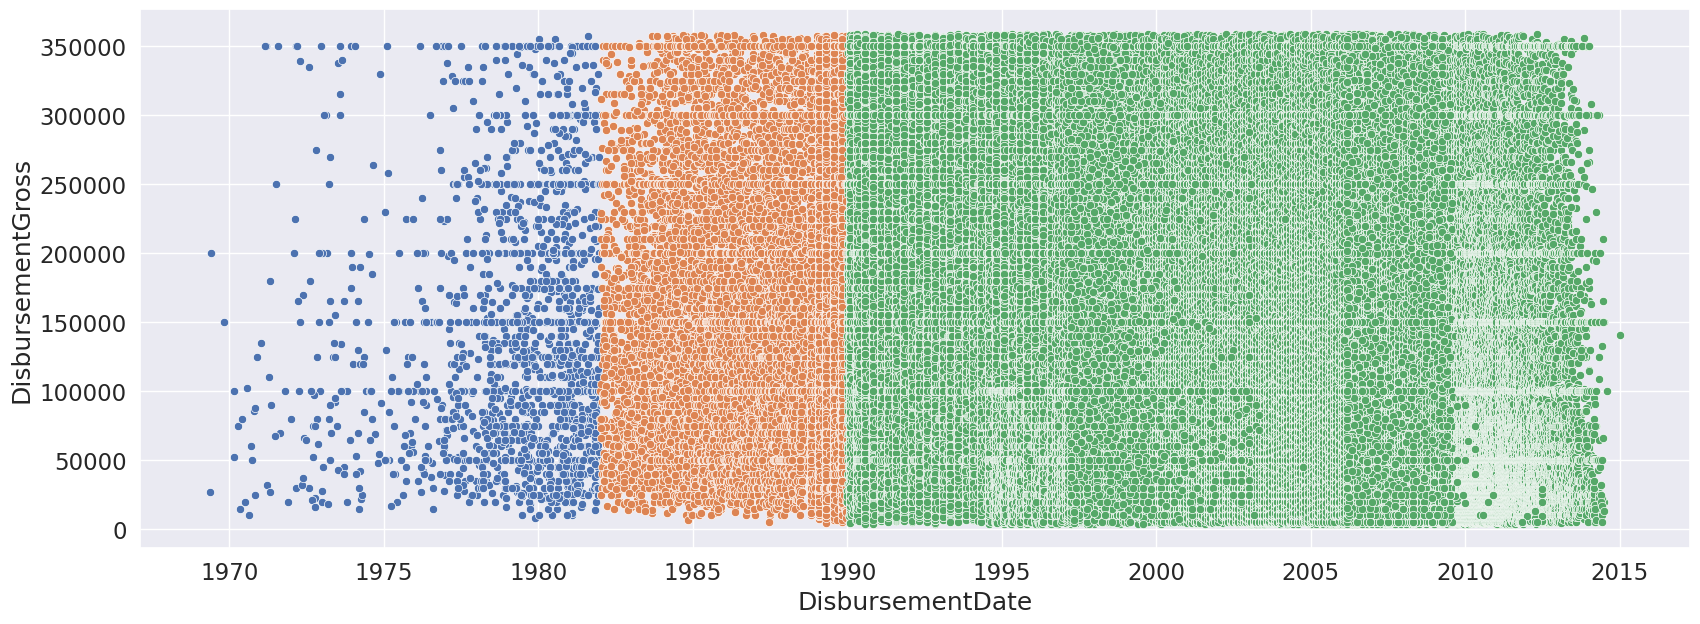

In [33]:
sns.scatterplot(data=cluster1_df, x="DisbursementDate", y="DisbursementGross")
sns.scatterplot(data=cluster2_df, x="DisbursementDate", y="DisbursementGross")
sns.scatterplot(data=cluster3_df, x="DisbursementDate", y="DisbursementGross")

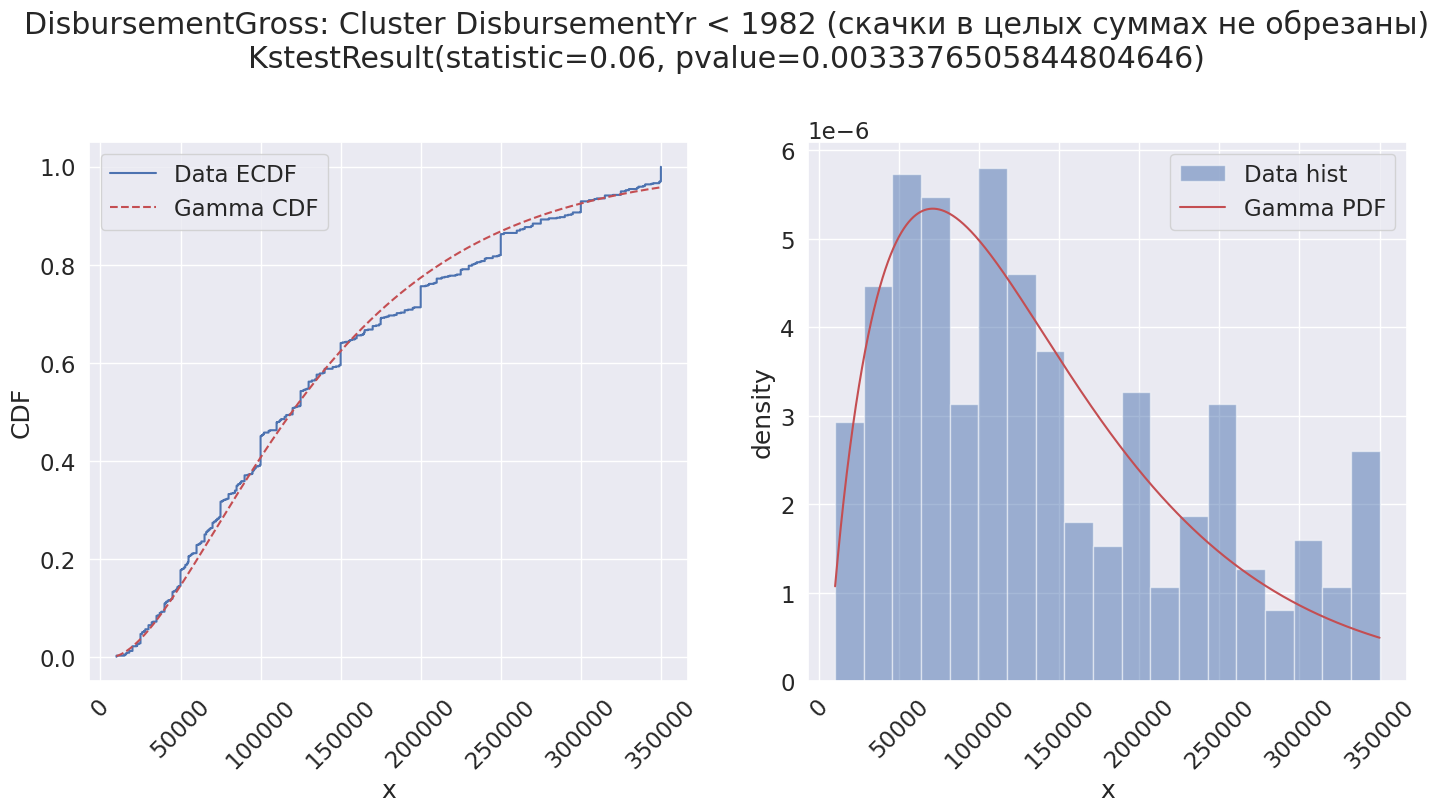

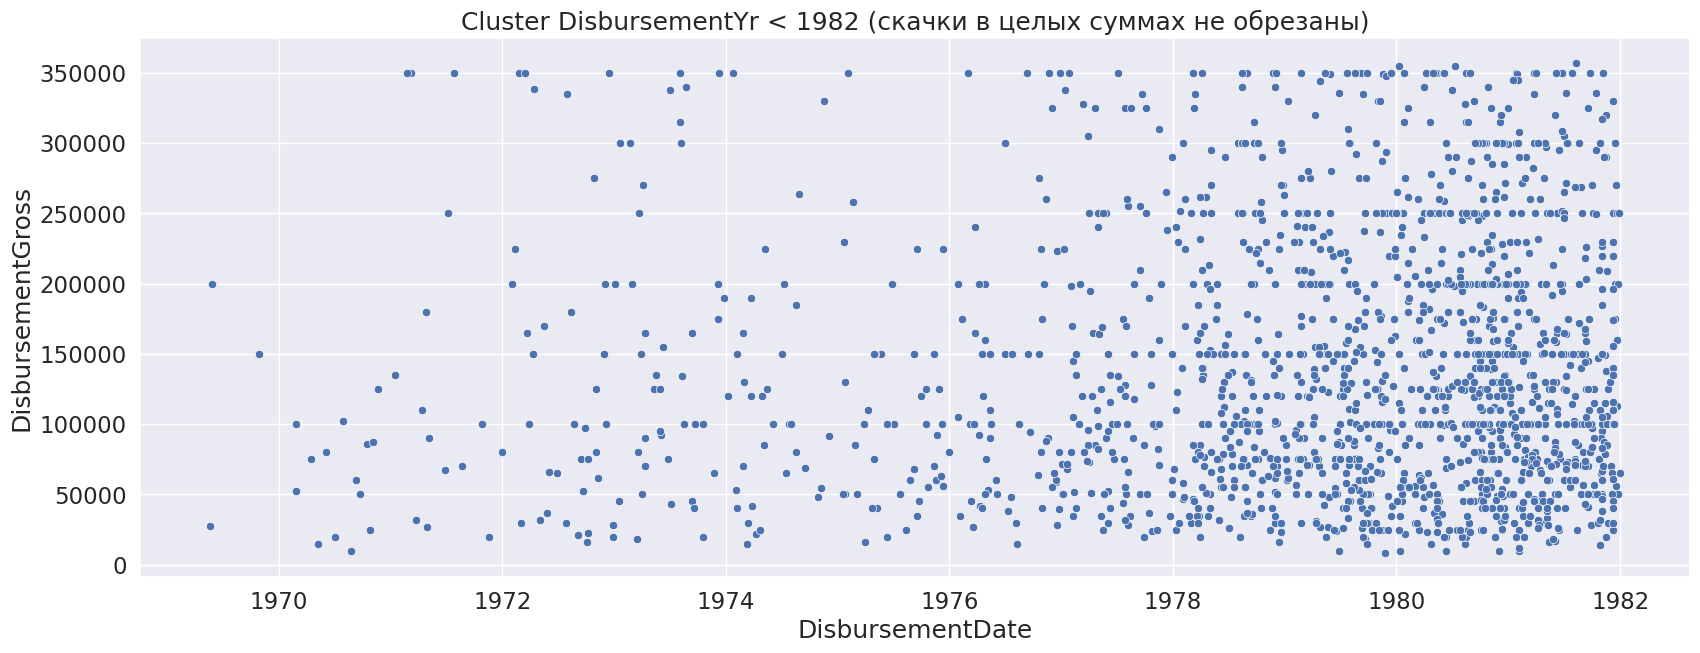

In [34]:
run_kstest(cluster1_df['DisbursementGross'], 
           distribution=gamma, 
           distribution_name="Gamma",
           title="DisbursementGross: Cluster DisbursementYr < 1982 (скачки в целых суммах не обрезаны)")
plt.title("Cluster DisbursementYr < 1982 (скачки в целых суммах не обрезаны)")
sns.scatterplot(data=cluster1_df, x="DisbursementDate", y="DisbursementGross", alpha=1, palette="rocket")
plt.show()

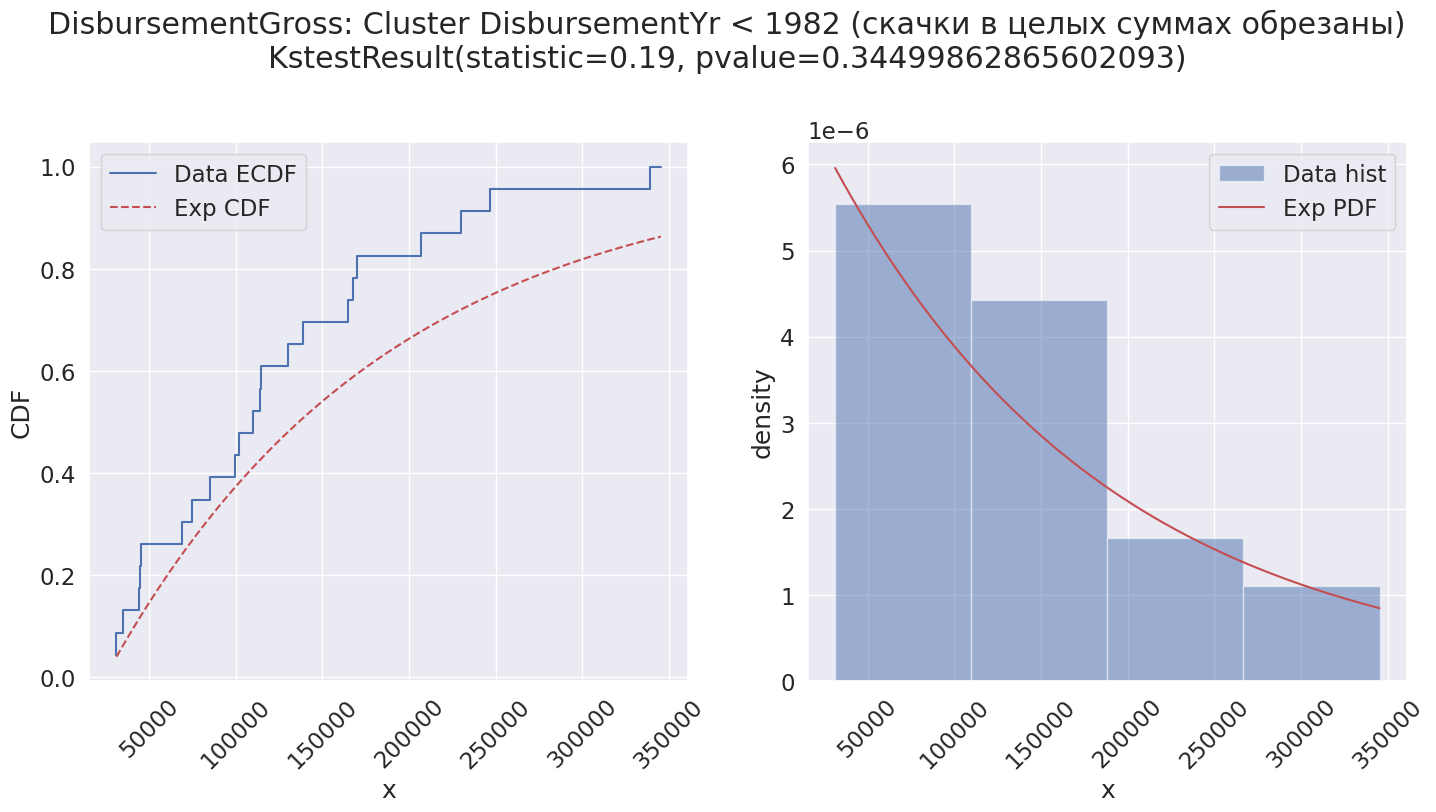

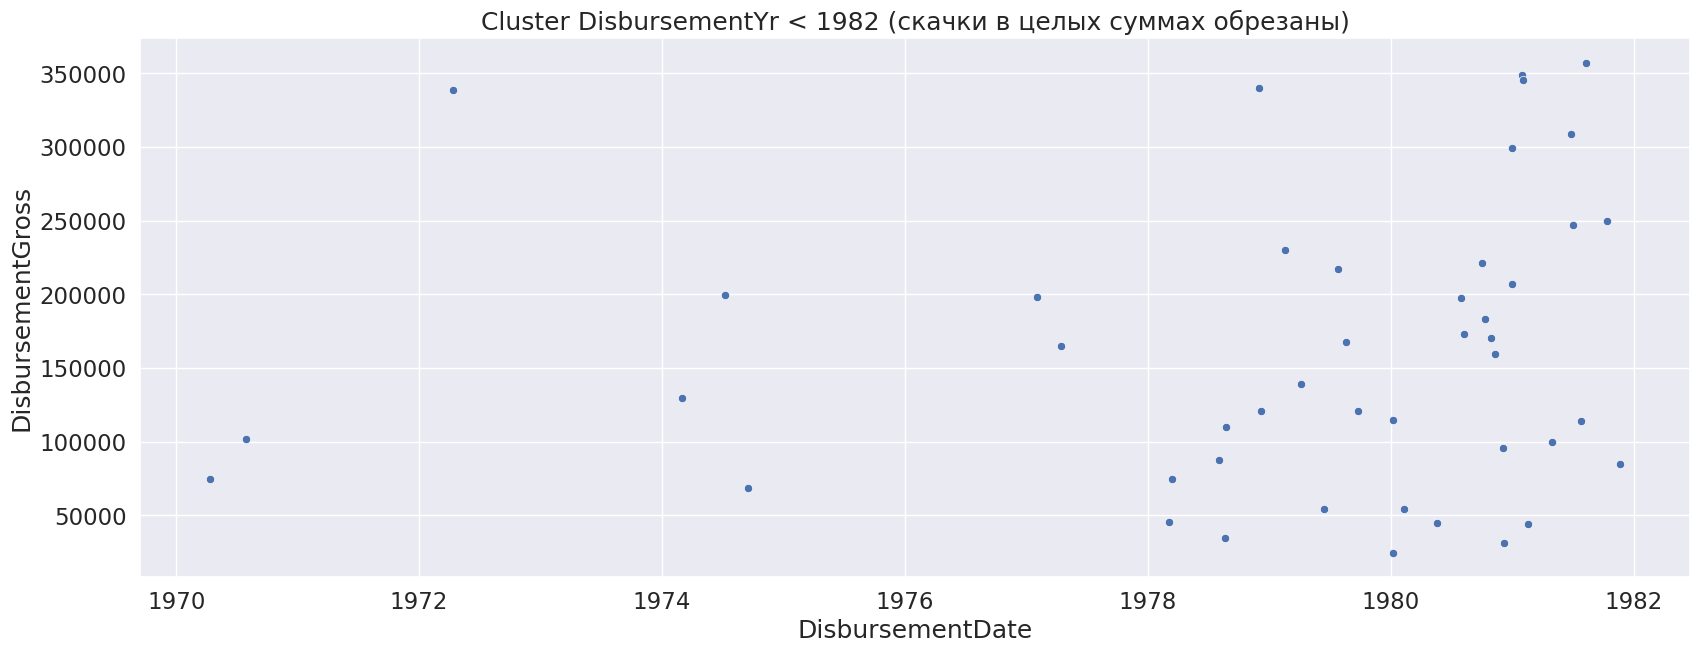

In [35]:
run_kstest(cluster1_df[(cluster1_df['DisbursementGross'] % 100 != 0)]['DisbursementGross'], 
           distribution=expon, 
           distribution_name="Exp",
           title="DisbursementGross: Cluster DisbursementYr < 1982 (скачки в целых суммах обрезаны)")
plt.title("Cluster DisbursementYr < 1982 (скачки в целых суммах обрезаны)")
sns.scatterplot(data=cluster1_df[(df['DisbursementGross'] % 100 != 0)], x="DisbursementDate", y="DisbursementGross", alpha=1, palette="rocket")
plt.show()

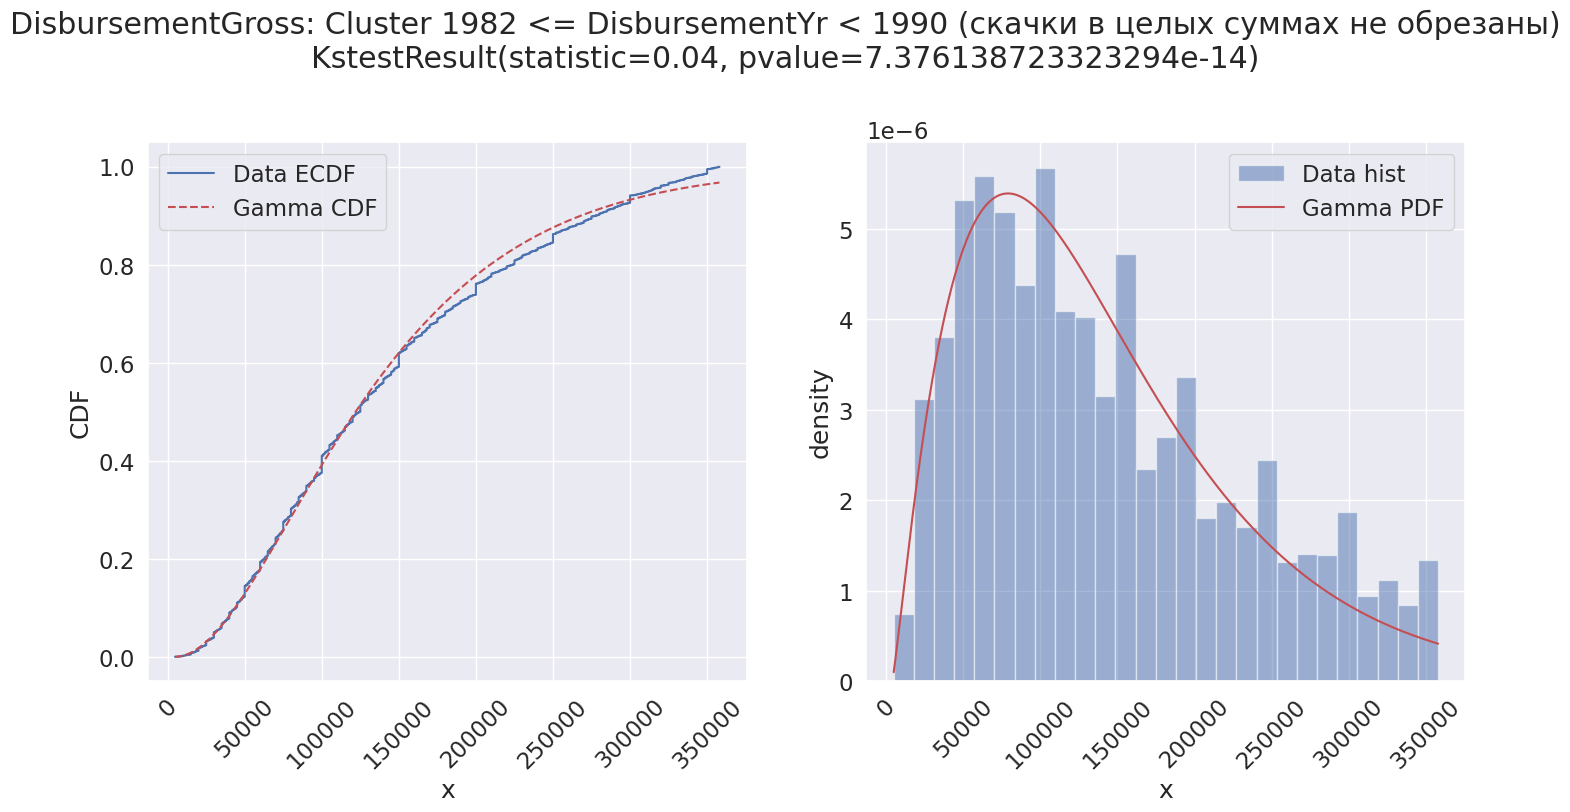

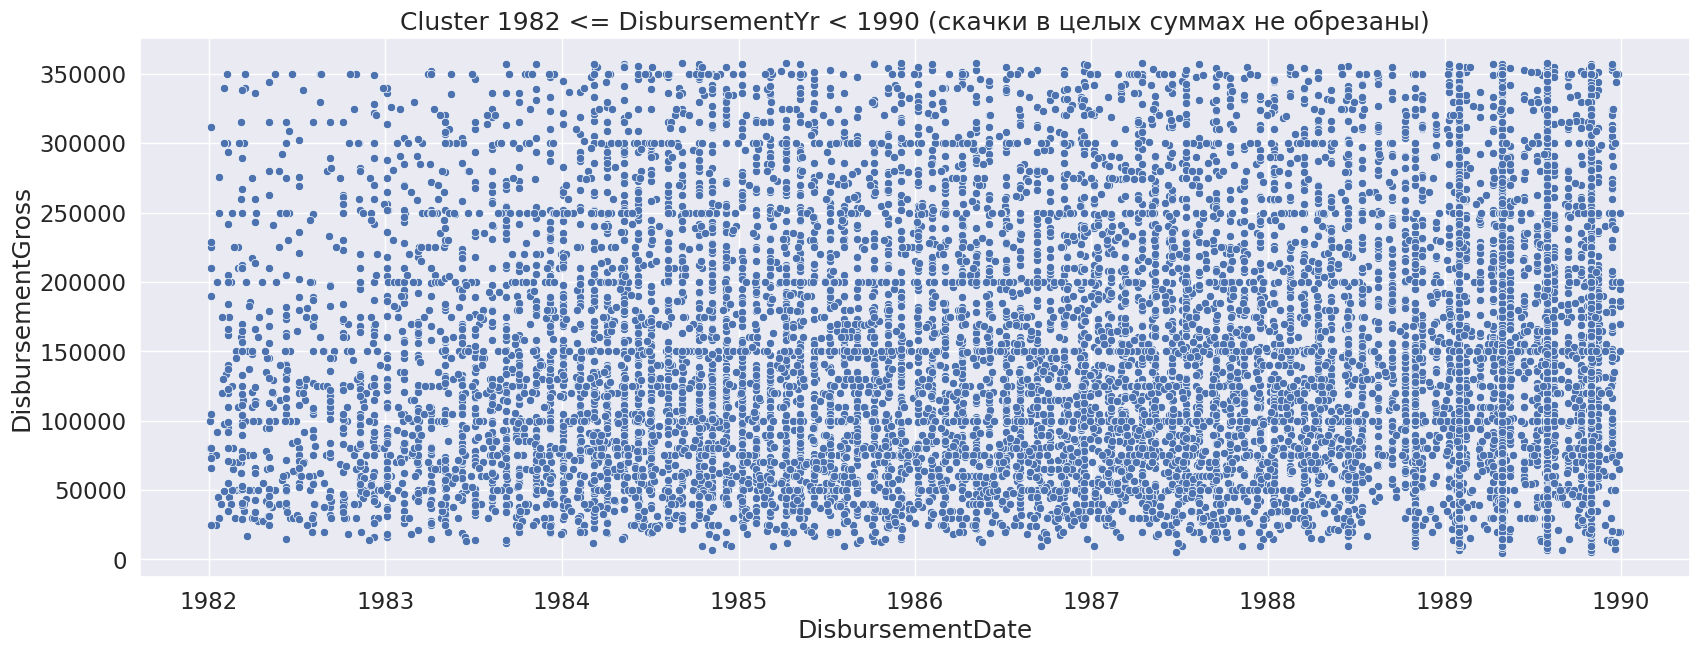

In [36]:
run_kstest(cluster2_df['DisbursementGross'], 
           distribution=gamma, 
           distribution_name="Gamma",
           title="DisbursementGross: Cluster 1982 <= DisbursementYr < 1990 (скачки в целых суммах не обрезаны)")
plt.title("Cluster 1982 <= DisbursementYr < 1990 (скачки в целых суммах не обрезаны)")
sns.scatterplot(data=cluster2_df, x="DisbursementDate", y="DisbursementGross", alpha=1, palette="rocket")
plt.show()

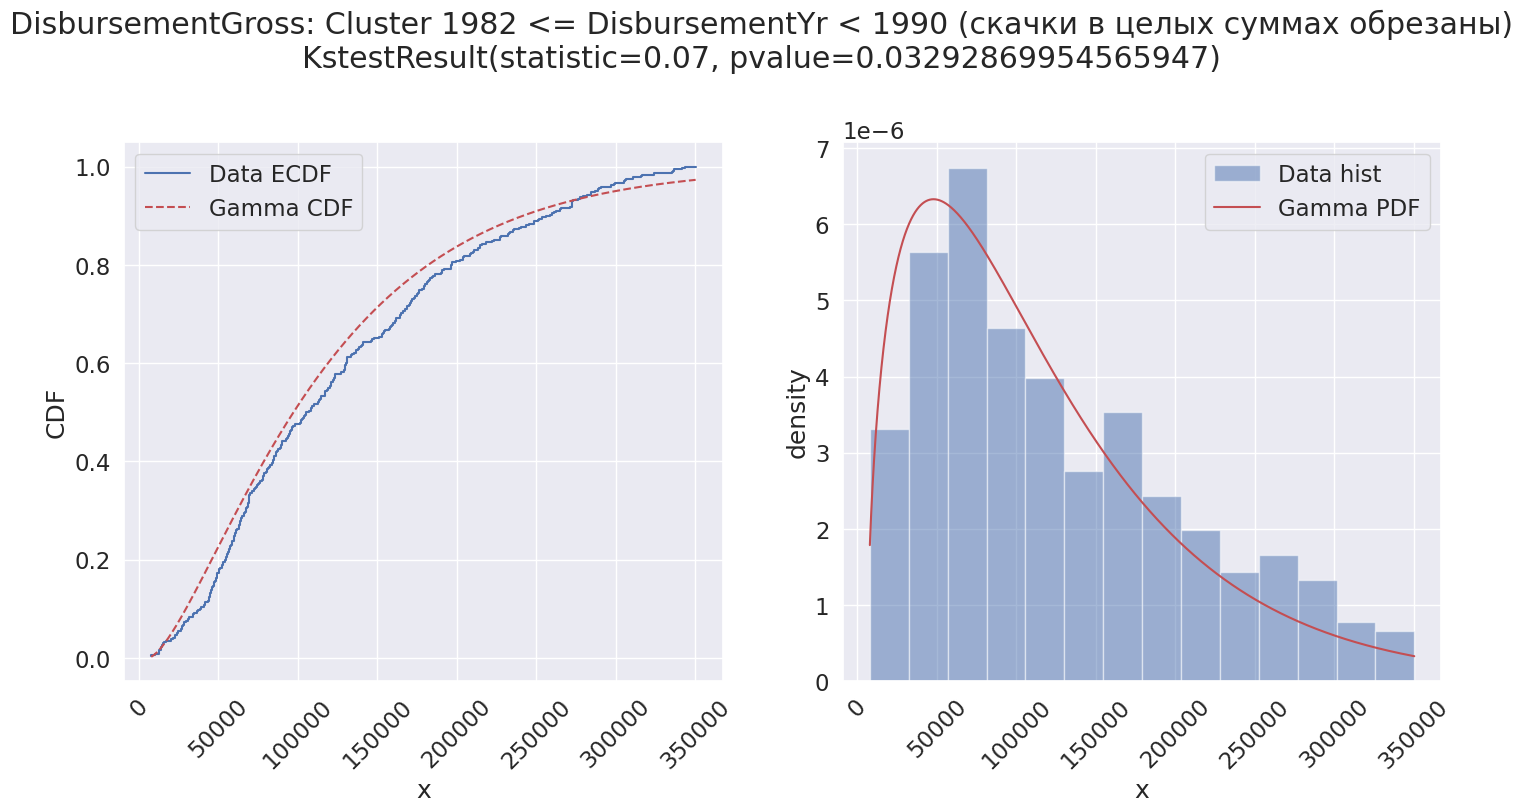

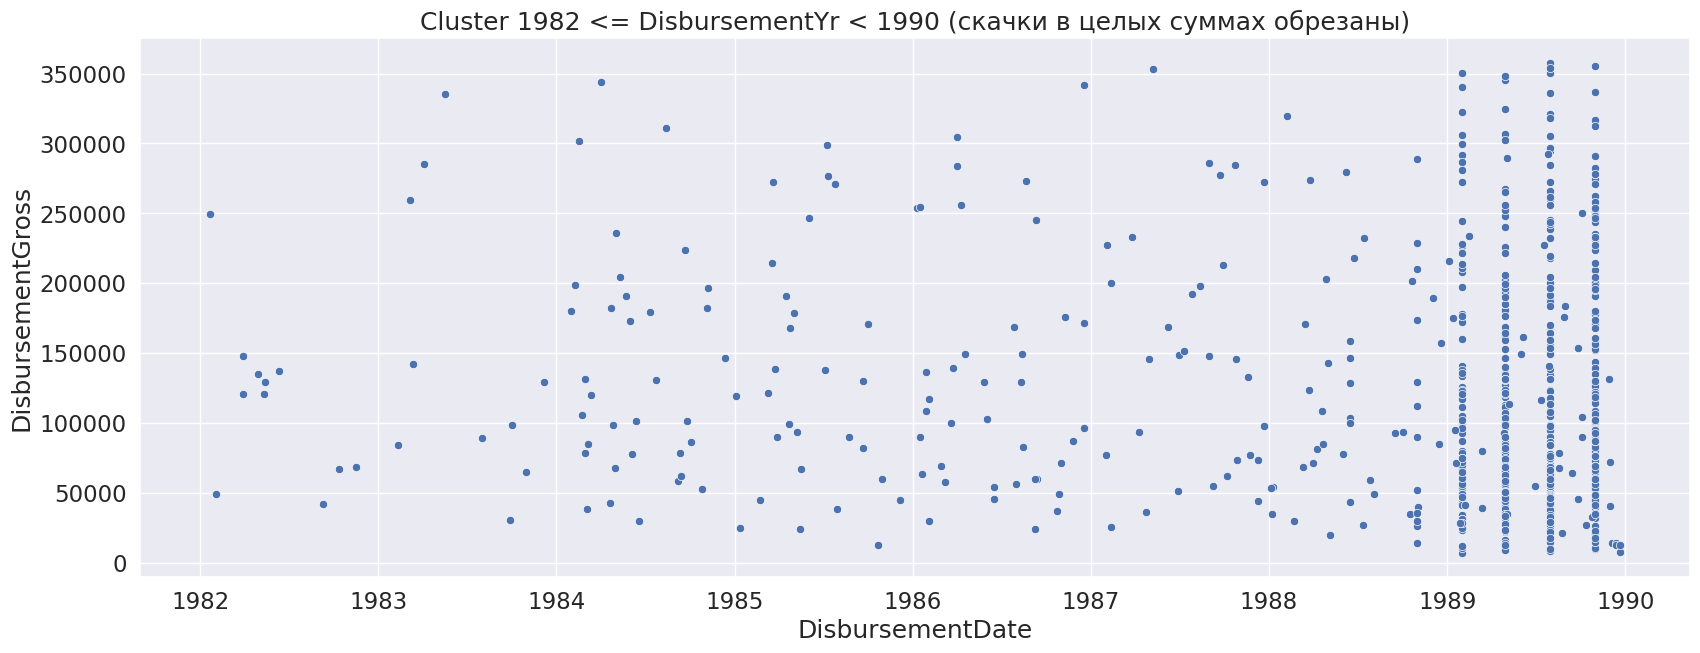

In [37]:
run_kstest(cluster2_df[(cluster2_df['DisbursementGross'] % 100 != 0)]['DisbursementGross'], 
           distribution=gamma, 
           distribution_name="Gamma",
           title="DisbursementGross: Cluster 1982 <= DisbursementYr < 1990 (скачки в целых суммах обрезаны)")
plt.title("Cluster 1982 <= DisbursementYr < 1990 (скачки в целых суммах обрезаны)")
sns.scatterplot(data=cluster2_df[(df['DisbursementGross'] % 100 != 0)], x="DisbursementDate", y="DisbursementGross", alpha=1, palette="rocket")
plt.show()

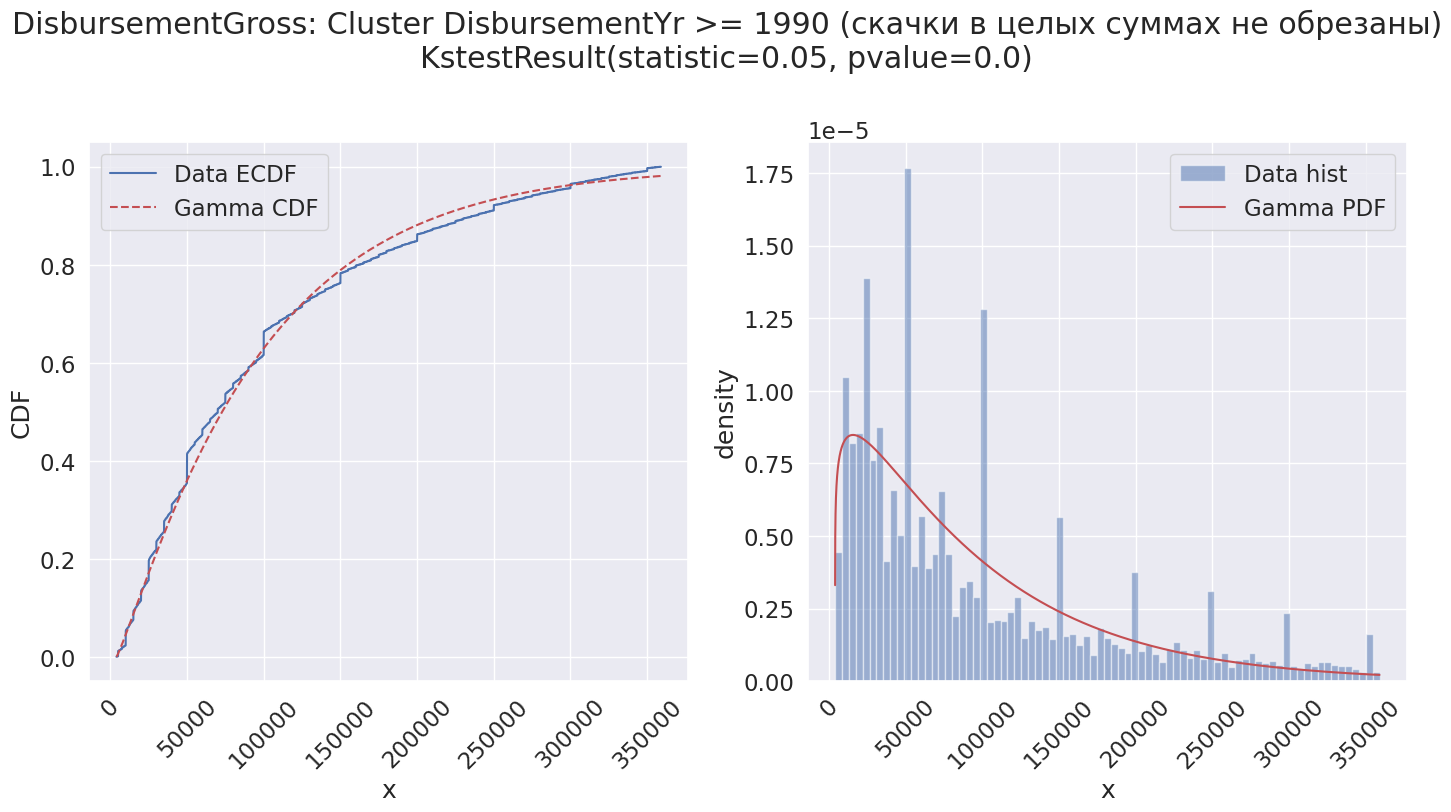

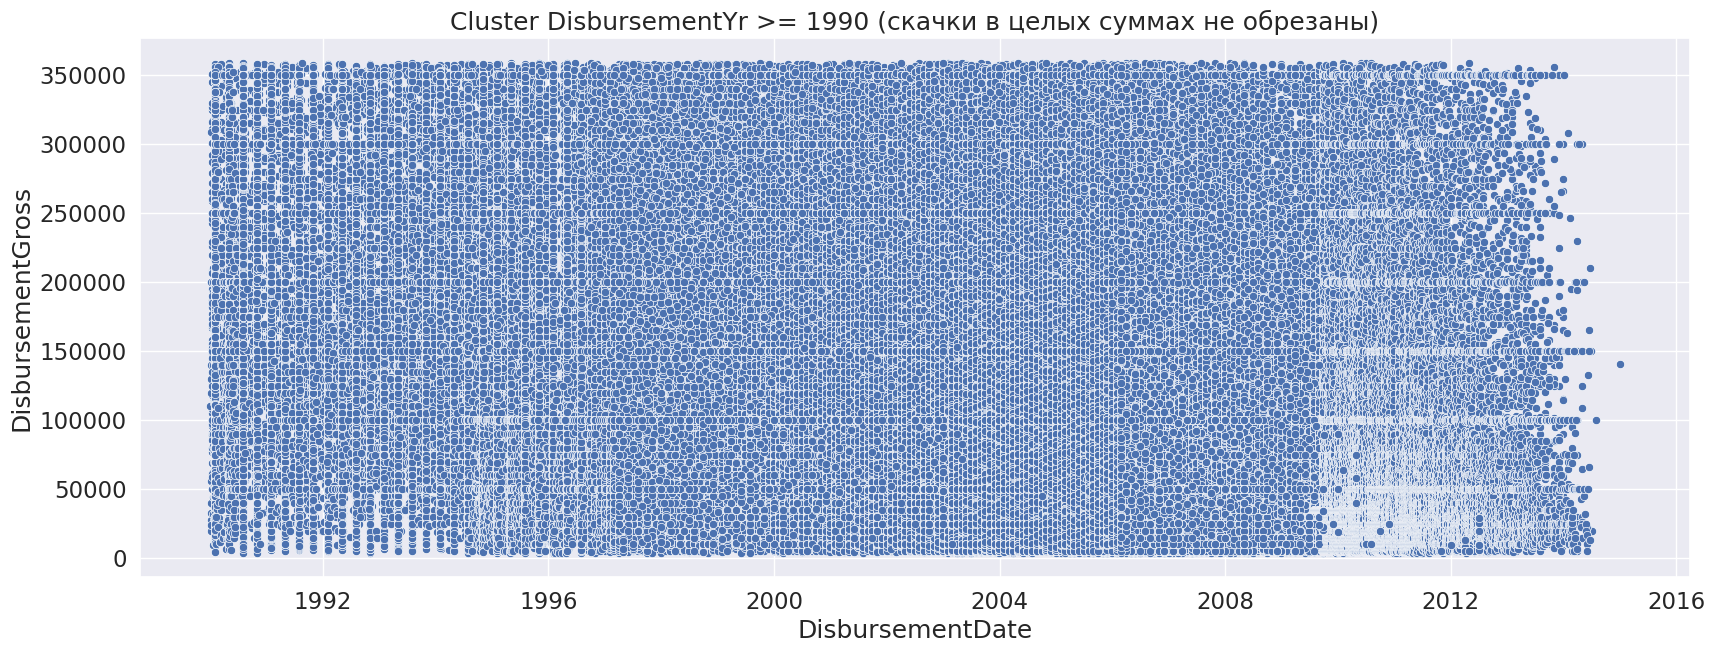

In [38]:
run_kstest(cluster3_df['DisbursementGross'], 
           distribution=gamma, 
           distribution_name="Gamma",
           title="DisbursementGross: Cluster DisbursementYr >= 1990 (скачки в целых суммах не обрезаны)")
plt.title("Cluster DisbursementYr >= 1990 (скачки в целых суммах не обрезаны)")
sns.scatterplot(data=cluster3_df, x="DisbursementDate", y="DisbursementGross", alpha=1, palette="rocket")
plt.show()

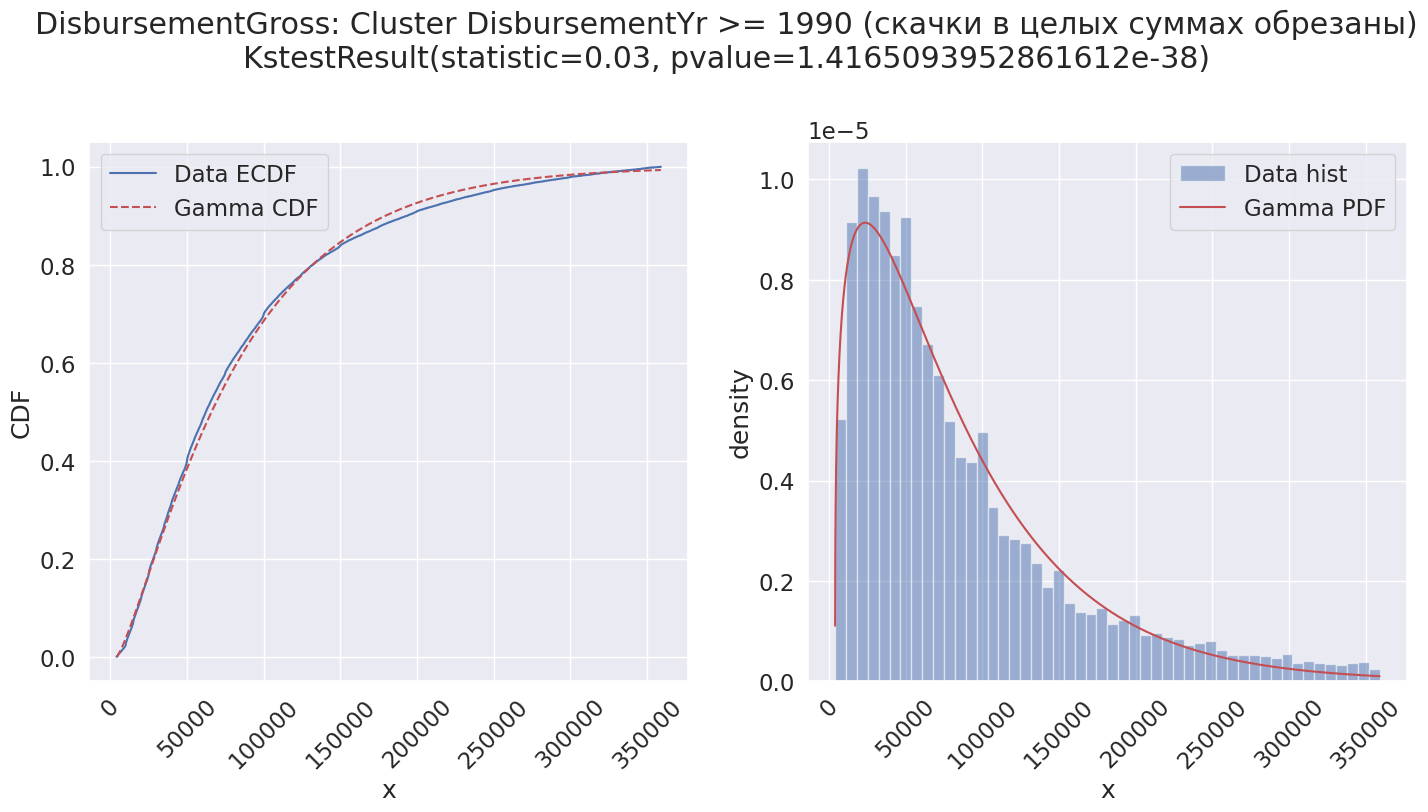

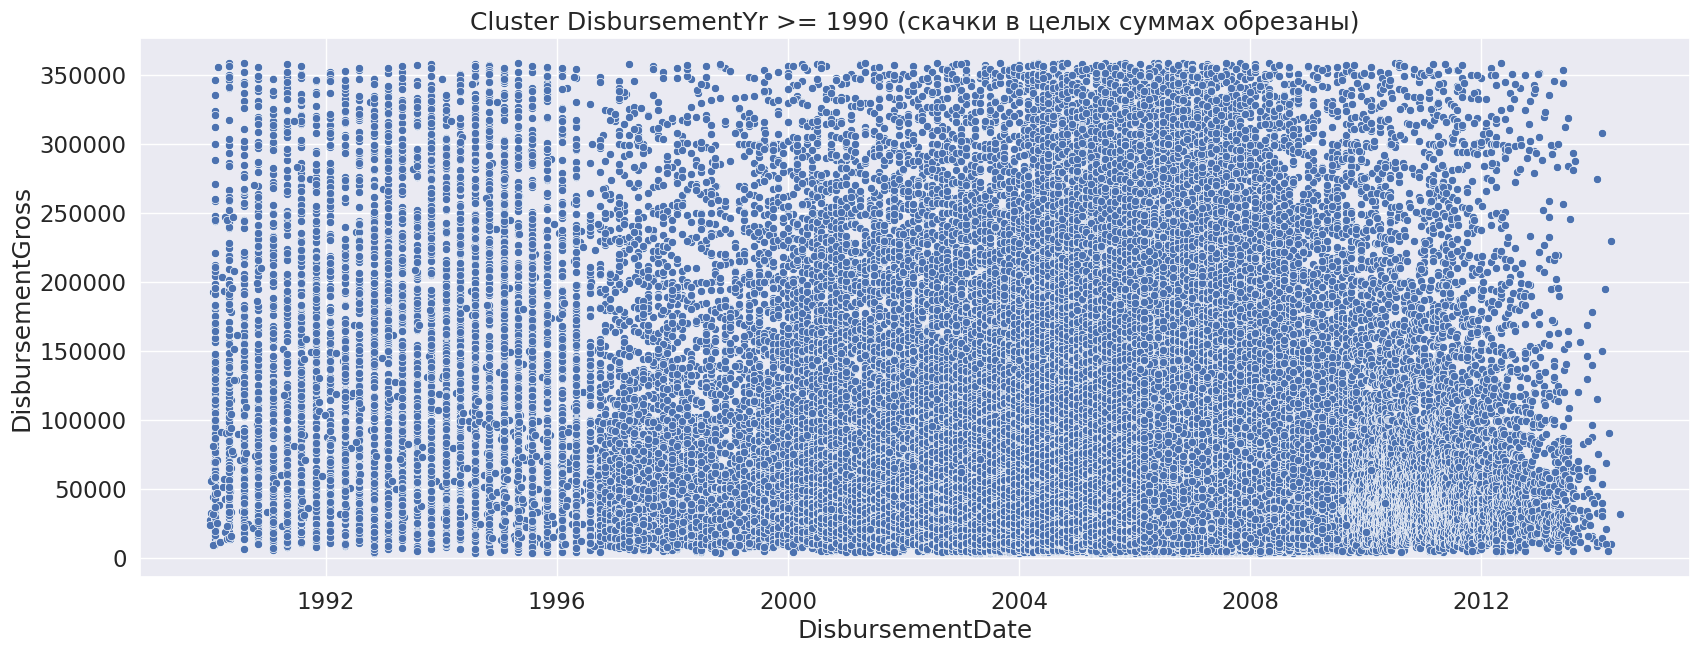

In [39]:
run_kstest(cluster3_df[(cluster3_df['DisbursementGross'] % 100 != 0)]['DisbursementGross'], 
           distribution=gamma, 
           distribution_name="Gamma",
           title="DisbursementGross: Cluster DisbursementYr >= 1990 (скачки в целых суммах обрезаны)")
plt.title("Cluster DisbursementYr >= 1990 (скачки в целых суммах обрезаны)")
sns.scatterplot(data=cluster3_df[(df['DisbursementGross'] % 100 != 0)], x="DisbursementDate", y="DisbursementGross", alpha=1, palette="rocket")
plt.show()

In [40]:
df_agg_M[df_agg_M.DisbursementYr >= 1990]

DisbursementDate  Средний Term  Средний NoEmp  DisbursementYr  \
237          1990-01    131.789110      21.744413          1990.0   
238          1990-02    183.552846      19.268293          1990.0   
239          1990-03    177.253425      19.082192          1990.0   
240          1990-04    128.984592      16.271327          1990.0   
241          1990-05    147.299094      13.187311          1990.0   
..               ...           ...            ...             ...   
528          2014-04     62.318182       6.772727          2014.0   
529          2014-05     71.631579      11.000000          2014.0   
530          2014-06     53.750000       7.750000          2014.0   
531          2014-07     72.000000     143.000000          2014.0   
532          2014-12     71.000000       3.000000          2014.0   

     Средний DisbursementGross  Средний CreateJob  Средний RetainedJob  \
237              135441.937500           0.619260             0.469321   
238              166335.312500           7.195122             7.756098   
239              154888.468750           5.856164             5.938356   
240              136543.718750           0.417888             0.290492   
241              144547.390625           2.945619             2.848943   
..                         ...                ...                  ...   
528               82182.500000           0.863636             5.681818   
529               79313.156250           1.210526             8.526316   
530               82691.664062           1.666667             4.916667   
531               60000.000000           0.000000           143.000000   
532              140800.000000           1.000000             3.000000   

     Процент NewBusiness  Процент LowDoc  Процент RevLineCr  Процент Default  \
237             0.275498             0.0           0.000000         0.058106   
238             0.317073             0.0           0.000000         0.056911   
239             0.294521             0.0           0.000000         0.041096   
240             0.264186             0.0           0.000000         0.046223   
241             0.247734             0.0           0.000000         0.066465   
..                   ...             ...                ...              ...   
528             0.227273             0.0           0.636364         0.000000   
529             0.157895             0.0           0.736842         0.000000   
530             0.500000             0.0           0.166667         0.000000   
531             0.500000             0.0           1.000000         0.000000   
532             0.000000             0.0           0.000000         0.000000   

    DisbursementMonthlyDate                 Cluster  
237              1990-01-01  DisbursementYr >= 1990  
238              1990-02-01  DisbursementYr >= 1990  
239              1990-03-01  DisbursementYr >= 1990  
240              1990-04-01  DisbursementYr >= 1990  
241              1990-05-01  DisbursementYr >= 1990  
..                      ...                     ...  
528              2014-04-01  DisbursementYr >= 1990  
529              2014-05-01  DisbursementYr >= 1990  
530              2014-06-01  DisbursementYr >= 1990  
531              2014-07-01  DisbursementYr >= 1990  
532              2014-12-01  DisbursementYr >= 1990  

[296 rows x 13 columns]

In [41]:
df

State NAICS  Term  NoEmp  CreateJob  RetainedJob  RevLineCr  LowDoc  \
0         IN    45    84      4          0            0          0       1   
1         IN    72    60      2          0            0          0       1   
2         IN    62   180      7          0            0          0       0   
3         OK   NaN    60      2          0            0          0       1   
4         FL   NaN   240     14          7            7          0       0   
...      ...   ...   ...    ...        ...          ...        ...     ...   
899158    TX   NaN    84      5          0            0          0       1   
899160    OH    45    60      6          0            0          1       0   
899161    CA    33   108     26          0            0          0       0   
899162    HI   NaN    60      6          0            0          0       1   
899163    HI   NaN    48      1          0            0          0       0   

       DisbursementDate  DisbursementGross  Default  DisbursementYr  \
0            1999-02-28            60000.0        0            1999   
1            1997-05-31            40000.0        0            1997   
2            1997-12-31           287000.0        0            1997   
3            1997-06-30            35000.0        0            1997   
4            1997-05-14           229000.0        0            1997   
...                 ...                ...      ...             ...   
899158       1997-06-30            79000.0        0            1997   
899160       1997-10-31            85000.0        0            1997   
899161       1997-09-30           300000.0        0            1997   
899162       1997-03-31            75000.0        1            1997   
899163       1997-05-31            30000.0        0            1997   

        DisbursementMo  NewBusiness      Clusters  
0                    2            1  LowCreateJob  
1                    5            1  LowCreateJob  
2                   12            0  LowCreateJob  
3                    6            0  LowCreateJob  
4                    5            0  LowCreateJob  
...                ...          ...           ...  
899158               6            1  LowCreateJob  
899160              10            0  LowCreateJob  
899161               9            0  LowCreateJob  
899162               3            0  LowCreateJob  
899163               5            1  LowCreateJob  

[525121 rows x 15 columns]

In [42]:
df[df.DisbursementYr<1990]

State NAICS  Term  NoEmp  CreateJob  RetainedJob  RevLineCr  LowDoc  \
43        IN   NaN   120     16          0            0          1       0   
171       NY   NaN    10     22          0            0          0       0   
456       NY   NaN   138     10          0            0          0       0   
481       IL   NaN    87     20          0            0          0       0   
489       IL   NaN    66      2          0            0          0       0   
...      ...   ...   ...    ...        ...          ...        ...     ...   
898349    RI   NaN   240     20          0            0          0       0   
898350    RI   NaN   240     17          0            0          0       0   
898351    RI   NaN   300     23          0            0          0       0   
898352    RI   NaN   240    114          0            0          0       0   
898373    VA    44   299      1          0            0          0       0   

       DisbursementDate  DisbursementGross  Default  DisbursementYr  \
43           1980-07-31           197485.0        1            1980   
171          1980-08-12           125000.0        1            1980   
456          1980-10-09           183642.0        1            1980   
481          1980-05-12           350000.0        1            1980   
489          1982-01-08            75000.0        1            1982   
...                 ...                ...      ...             ...   
898349       1983-01-05           252000.0        0            1983   
898350       1982-09-08           145000.0        0            1982   
898351       1981-12-09           135000.0        0            1981   
898352       1982-10-06           315000.0        0            1982   
898373       1987-04-01            50000.0        0            1987   

        DisbursementMo  NewBusiness      Clusters  
43                   7            1  LowCreateJob  
171                  8            1  LowCreateJob  
456                 10            0  LowCreateJob  
481                  5            0  LowCreateJob  
489                  1            1  LowCreateJob  
...                ...          ...           ...  
898349               1            1  LowCreateJob  
898350               9            0  LowCreateJob  
898351              12            1  LowCreateJob  
898352              10            1  LowCreateJob  
898373               4            0  LowCreateJob  

[21691 rows x 15 columns]

In [43]:
cluster3_df[cluster3_df.CreateJob >= 200].value_counts()

State  NAICS  Term  NoEmp  CreateJob  RetainedJob  RevLineCr  LowDoc  DisbursementDate  DisbursementGross  Default  DisbursementYr  DisbursementMo  NewBusiness  Clusters       
AL     81     120   12     450        12           0          0       2006-09-30        202500.0           0        2006            9               1            LowMidCreateJob    1
TX     54     40    1      500        1            1          0       2007-11-30        55448.0            1        2007            11              1            LowMidCreateJob    1
UT     23     240   110    500        110          0          0       1997-10-15        260000.0           0        1997            10              0            LowMidCreateJob    1
              84    5      454        0            1          0       2007-11-30        47265.0            0        2007            11              1            LowMidCreateJob    1
                    4      452        0            1          0       2007-02-28        40000.0

In [44]:
cluster3_df

State NAICS  Term  NoEmp  CreateJob  RetainedJob  RevLineCr  LowDoc  \
0         IN    45    84      4          0            0          0       1   
1         IN    72    60      2          0            0          0       1   
2         IN    62   180      7          0            0          0       0   
3         OK   NaN    60      2          0            0          0       1   
4         FL   NaN   240     14          7            7          0       0   
...      ...   ...   ...    ...        ...          ...        ...     ...   
899158    TX   NaN    84      5          0            0          0       1   
899160    OH    45    60      6          0            0          1       0   
899161    CA    33   108     26          0            0          0       0   
899162    HI   NaN    60      6          0            0          0       1   
899163    HI   NaN    48      1          0            0          0       0   

       DisbursementDate  DisbursementGross  Default  DisbursementYr  \
0            1999-02-28            60000.0        0            1999   
1            1997-05-31            40000.0        0            1997   
2            1997-12-31           287000.0        0            1997   
3            1997-06-30            35000.0        0            1997   
4            1997-05-14           229000.0        0            1997   
...                 ...                ...      ...             ...   
899158       1997-06-30            79000.0        0            1997   
899160       1997-10-31            85000.0        0            1997   
899161       1997-09-30           300000.0        0            1997   
899162       1997-03-31            75000.0        1            1997   
899163       1997-05-31            30000.0        0            1997   

        DisbursementMo  NewBusiness      Clusters  
0                    2            1  LowCreateJob  
1                    5            1  LowCreateJob  
2                   12            0  LowCreateJob  
3                    6            0  LowCreateJob  
4                    5            0  LowCreateJob  
...                ...          ...           ...  
899158               6            1  LowCreateJob  
899160              10            0  LowCreateJob  
899161               9            0  LowCreateJob  
899162               3            0  LowCreateJob  
899163               5            1  LowCreateJob  

[503430 rows x 15 columns]

In [45]:
cluster3_df = cluster3_df[cluster3_df.CreateJob <= 200]
cluster3_df.NAICS.isna().count()

503318

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

default0, default1 = cluster3_df[cluster3_df.Default == 0],  cluster3_df[cluster3_df.Default == 1]

default0 = default0.sample(default1.shape[0], random_state=42)

df_upd = pd.concat([default0, default1], axis=0)

df_upd = df_upd.sample(frac=1)

X_train, X_test, y_train, y_test = train_test_split(df_upd[['DisbursementGross', 'NoEmp', 'Term', 'CreateJob', 'RevLineCr']], df_upd["Default"], test_size=0.2, random_state=42 )
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
probabilities = logisticRegr.predict_proba(X_test)
logisticRegr.score(X_test, y_test)

0.7763462428637556

In [47]:
w = ['DisbursementGross', 'NoEmp', 'Term', 'CreateJob', 'RevLineCr']
for i, j in zip(w, logisticRegr.coef_[0]):
    print(f"{i}: Weight {j}")

DisbursementGross: Weight -0.02386296393841174
NoEmp: Weight -0.9470065227037562
Term: Weight -2.1381853954576955
CreateJob: Weight 0.1725363710934398
RevLineCr: Weight -0.052209889400354266


Accuracy (overall correct predictions): 0.78
Auc: 0.84
Recall (all 1s predicted right): 0.81
Precision (confidence when predicting a 1): 0.76
F1 score: 0.78
Detail:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77     19350
           1       0.76      0.81      0.78     19536

    accuracy                           0.78     38886
   macro avg       0.78      0.78      0.78     38886
weighted avg       0.78      0.78      0.78     38886



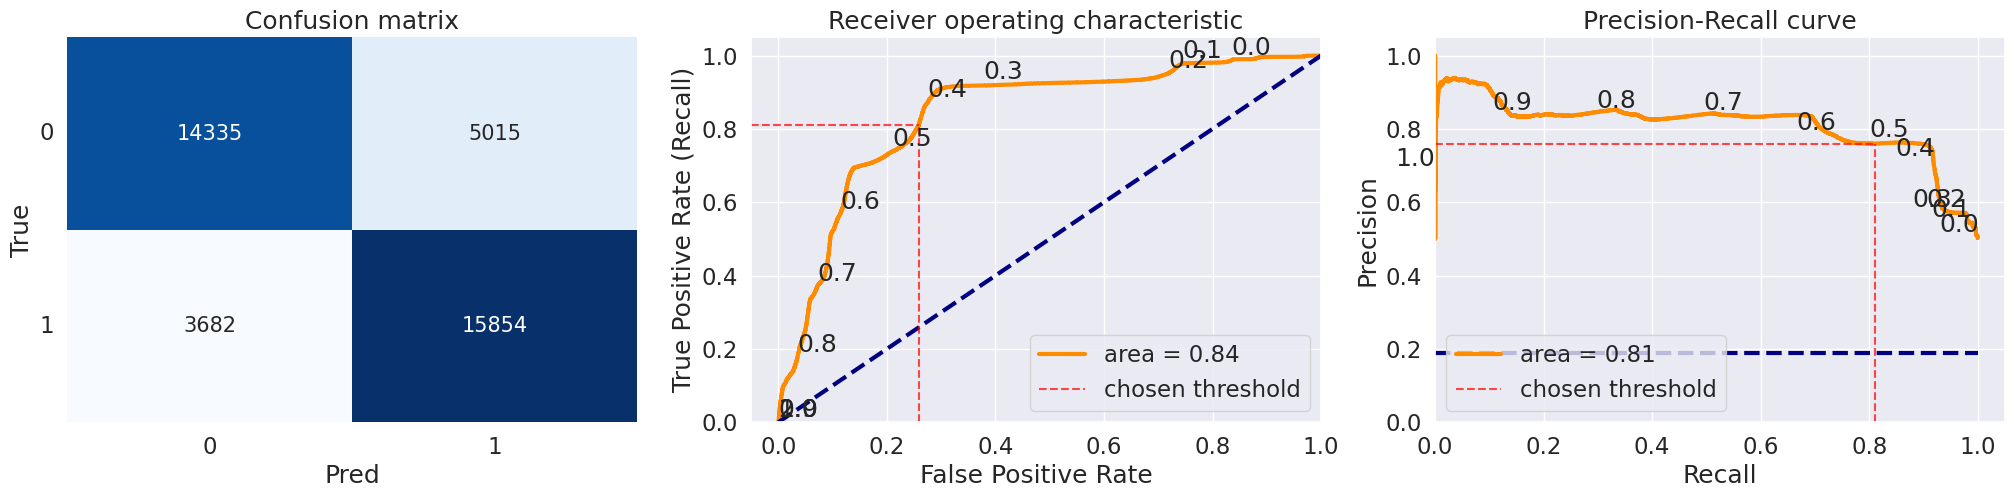

In [48]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from utils import evaluate_classif_model

evaluate_classif_model(y_test, predictions, probabilities.T[1])

In [49]:
from sklearn import metrics
auc = metrics.roc_auc_score(y_test, probabilities.T[1])
auc

0.8393797153390177

In [50]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
k = poly.fit_transform(df_upd[['DisbursementGross', 'NoEmp', 'Term', 'CreateJob', 'RevLineCr']])
X_train, X_test, y_train, y_test = train_test_split(k, df_upd["Default"], test_size=0.2, random_state=42 )
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)

logisticRegr.score(X_test, y_test), logisticRegr.coef_

(0.7788407138816026,
 array([[ 0.        , -0.58128471, -2.20891801, -2.41678237,  1.12376965,
          0.43003958,  0.13520469,  0.57609962,  0.9344869 , -0.3657304 ,
          0.02220018,  1.4325562 , -0.17304985, -0.07806069,  0.2964856 ,
          0.60870577, -0.4900685 , -0.91654088, -0.27285825, -0.35069539,
          0.43003958]]))

In [51]:
w= poly.get_feature_names_out(input_features=['DisbursementGross', 'NoEmp', 'Term', 'CreateJob', 'RevLineCr'])
for i, j in zip(w, logisticRegr.coef_[0]):
    print(f"{i}: Weight {j}")

1: Weight 0.0
DisbursementGross: Weight -0.5812847086710923
NoEmp: Weight -2.2089180083229536
Term: Weight -2.416782370461491
CreateJob: Weight 1.1237696470563696
RevLineCr: Weight 0.43003958106769863
DisbursementGross^2: Weight 0.13520469175353586
DisbursementGross NoEmp: Weight 0.5760996207342524
DisbursementGross Term: Weight 0.9344868974746824
DisbursementGross CreateJob: Weight -0.3657304009618869
DisbursementGross RevLineCr: Weight 0.02220017952750566
NoEmp^2: Weight 1.432556201824602
NoEmp Term: Weight -0.17304984908646895
NoEmp CreateJob: Weight -0.07806068688043721
NoEmp RevLineCr: Weight 0.29648559785750533
Term^2: Weight 0.6087057667790681
Term CreateJob: Weight -0.4900685041422321
Term RevLineCr: Weight -0.9165408829401575
CreateJob^2: Weight -0.27285824817797655
CreateJob RevLineCr: Weight -0.3506953877092622
RevLineCr^2: Weight 0.43003958106769696


Accuracy (overall correct predictions): 0.78
Auc: 0.84
Recall (all 1s predicted right): 0.78
Precision (confidence when predicting a 1): 0.78
F1 score: 0.78
Detail:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78     19350
           1       0.78      0.78      0.78     19536

    accuracy                           0.78     38886
   macro avg       0.78      0.78      0.78     38886
weighted avg       0.78      0.78      0.78     38886



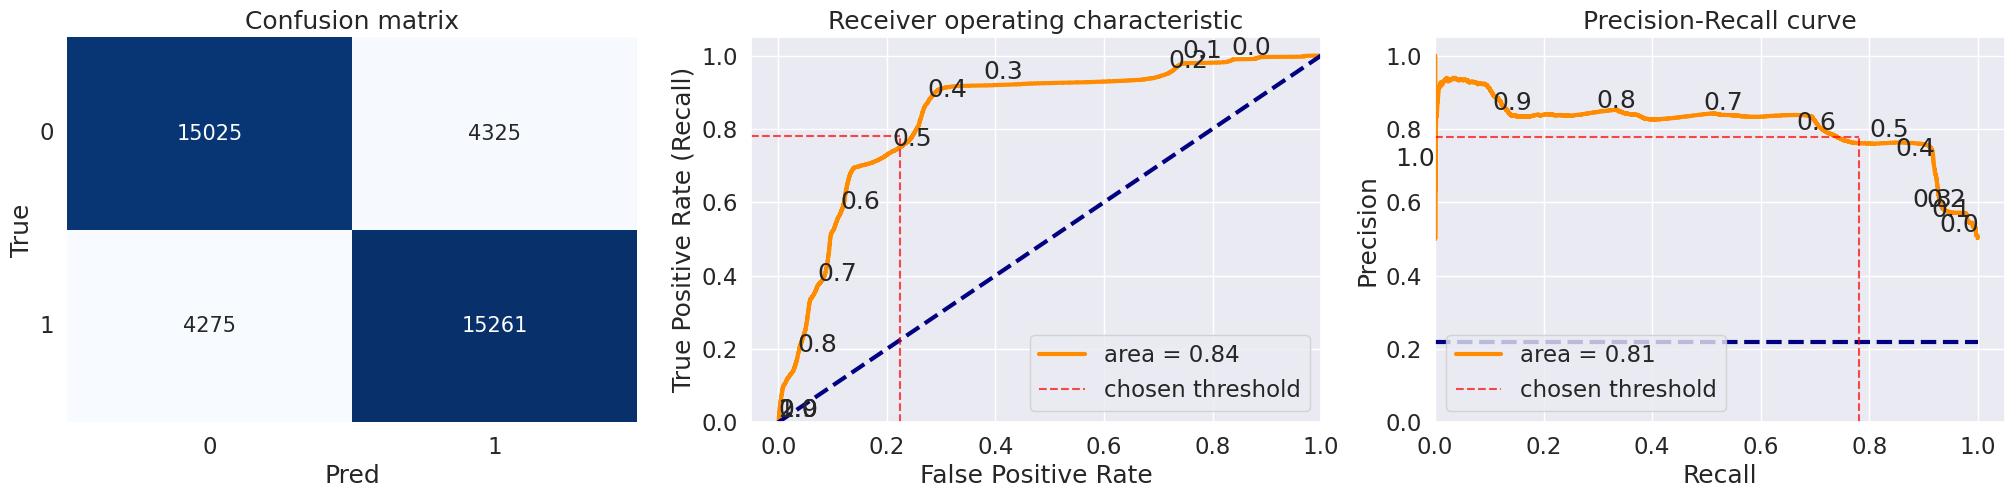

In [52]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


evaluate_classif_model(y_test, predictions, probabilities.T[1])

In [53]:
df_agg_M

DisbursementDate  Средний Term  Средний NoEmp  DisbursementYr  \
0            1969-05    171.000000       5.500000          1969.0   
1            1969-10     84.000000      34.000000          1969.0   
2            1970-02    240.000000      11.500000          1970.0   
3            1970-04     60.000000      11.000000          1970.0   
4            1970-05    421.000000       4.000000          1970.0   
..               ...           ...            ...             ...   
528          2014-04     62.318182       6.772727          2014.0   
529          2014-05     71.631579      11.000000          2014.0   
530          2014-06     53.750000       7.750000          2014.0   
531          2014-07     72.000000     143.000000          2014.0   
532          2014-12     71.000000       3.000000          2014.0   

     Средний DisbursementGross  Средний CreateJob  Средний RetainedJob  \
0                113600.000000           0.000000             0.000000   
1                150000.000000           0.000000             0.000000   
2                 76250.000000           0.000000             0.000000   
3                 74952.000000           0.000000             0.000000   
4                 15000.000000           0.000000             0.000000   
..                         ...                ...                  ...   
528               82182.500000           0.863636             5.681818   
529               79313.156250           1.210526             8.526316   
530               82691.664062           1.666667             4.916667   
531               60000.000000           0.000000           143.000000   
532              140800.000000           1.000000             3.000000   

     Процент NewBusiness  Процент LowDoc  Процент RevLineCr  Процент Default  \
0               0.500000             0.0           0.000000              0.5   
1               0.000000             0.0           0.000000              1.0   
2               0.000000             0.0           0.000000              1.0   
3               0.000000             0.0           0.000000              1.0   
4               0.000000             0.0           0.000000              1.0   
..                   ...             ...                ...              ...   
528             0.227273             0.0           0.636364              0.0   
529             0.157895             0.0           0.736842              0.0   
530             0.500000             0.0           0.166667              0.0   
531             0.500000             0.0           1.000000              0.0   
532             0.000000             0.0           0.000000              0.0   

    DisbursementMonthlyDate                 Cluster  
0                1969-05-01   DisbursementYr < 1982  
1                1969-10-01   DisbursementYr < 1982  
2                1970-02-01   DisbursementYr < 1982  
3                1970-04-01   DisbursementYr < 1982  
4                1970-05-01   DisbursementYr < 1982  
..                      ...                     ...  
528              2014-04-01  DisbursementYr >= 1990  
529              2014-05-01  DisbursementYr >= 1990  
530              2014-06-01  DisbursementYr >= 1990  
531              2014-07-01  DisbursementYr >= 1990  
532              2014-12-01  DisbursementYr >= 1990  

[533 rows x 13 columns]

In [54]:
# X_train, X_test, y_train, y_test = train_test_split(df_agg_M[['Средний DisbursementGross', 'Средний NoEmp', 'Средний Term', 'Средний CreateJob', 'Процент RevLineCr']], 
#                                                     np.array([1-df_agg_M["Процент Default"], df_agg_M["Процент Default"]]).T, test_size=0.2, random_state=42 )
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# logisticRegr = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
# logisticRegr.fit(X_train, y_train)
# predictions = logisticRegr.predict(X_test)
# logisticRegr.score(X_test, y_test)
df_agg_M = df_agg_M[df_agg_M["Процент Default"] != 1]
df_agg_M =  df_agg_M[df_agg_M["Процент Default"] != 0]
df_agg_M = df_agg_M[df_agg_M.DisbursementYr >= 1990]
df_agg_M

DisbursementDate  Средний Term  Средний NoEmp  DisbursementYr  \
237          1990-01    131.789110      21.744413          1990.0   
238          1990-02    183.552846      19.268293          1990.0   
239          1990-03    177.253425      19.082192          1990.0   
240          1990-04    128.984592      16.271327          1990.0   
241          1990-05    147.299094      13.187311          1990.0   
..               ...           ...            ...             ...   
522          2013-10     72.830769      11.692308          2013.0   
523          2013-11     73.594595       5.405405          2013.0   
524          2013-12     63.585714       9.071429          2013.0   
525          2014-01     63.787879      14.909091          2014.0   
526          2014-02     63.250000       7.325000          2014.0   

     Средний DisbursementGross  Средний CreateJob  Средний RetainedJob  \
237              135441.937500           0.619260             0.469321   
238              166335.312500           7.195122             7.756098   
239              154888.468750           5.856164             5.938356   
240              136543.718750           0.417888             0.290492   
241              144547.390625           2.945619             2.848943   
..                         ...                ...                  ...   
522               92126.320312           3.369231             7.492308   
523               75329.093750           3.040541             4.418919   
524               93398.414062           2.457143             5.614286   
525               81725.625000           3.757576             7.818182   
526               56369.800781           2.425000             1.775000   

     Процент NewBusiness  Процент LowDoc  Процент RevLineCr  Процент Default  \
237             0.275498             0.0           0.000000         0.058106   
238             0.317073             0.0           0.000000         0.056911   
239             0.294521             0.0           0.000000         0.041096   
240             0.264186             0.0           0.000000         0.046223   
241             0.247734             0.0           0.000000         0.066465   
..                   ...             ...                ...              ...   
522             0.230769             0.0           0.461538         0.046154   
523             0.337838             0.0           0.486486         0.040541   
524             0.257143             0.0           0.571429         0.042857   
525             0.257576             0.0           0.484848         0.060606   
526             0.300000             0.0           0.525000         0.025000   

    DisbursementMonthlyDate                 Cluster  
237              1990-01-01  DisbursementYr >= 1990  
238              1990-02-01  DisbursementYr >= 1990  
239              1990-03-01  DisbursementYr >= 1990  
240              1990-04-01  DisbursementYr >= 1990  
241              1990-05-01  DisbursementYr >= 1990  
..                      ...                     ...  
522              2013-10-01  DisbursementYr >= 1990  
523              2013-11-01  DisbursementYr >= 1990  
524              2013-12-01  DisbursementYr >= 1990  
525              2014-01-01  DisbursementYr >= 1990  
526              2014-02-01  DisbursementYr >= 1990  

[276 rows x 13 columns]

In [55]:
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(df_agg_M[['Средний DisbursementGross', 'Средний NoEmp', 'Средний Term', 'Средний CreateJob', 'Процент RevLineCr']], 
                                                     np.log(df_agg_M["Процент Default"]/(1-df_agg_M["Процент Default"])), test_size=0.2, random_state=42 )
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression().fit(X_train, y_train)

# predictions = logisticRegr.predict(X_test)
y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.7139788809548875

R2 (explained variance): 0.71
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.29
Mean Absolute Error (Σ|y-pred|/n): 0.515
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.642
Max Error: -2


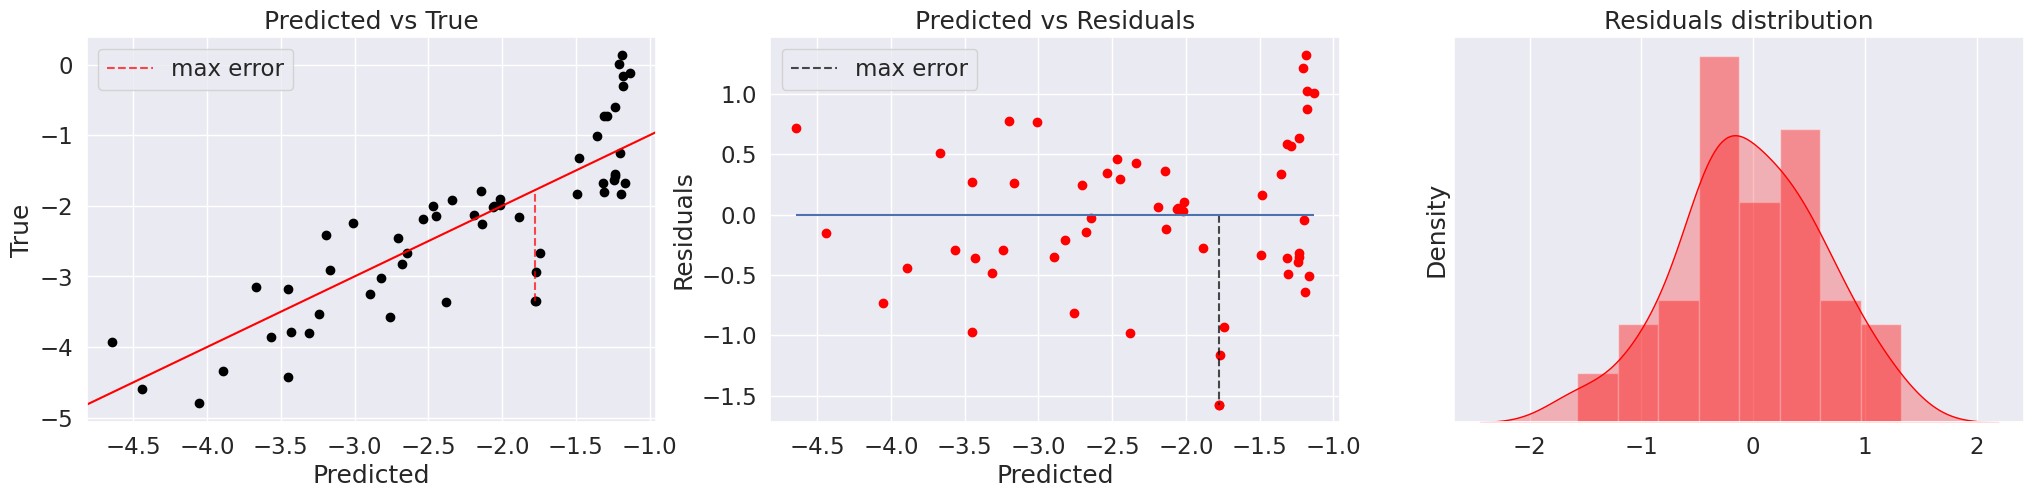

In [56]:
from utils import evaluate_regr_model
evaluate_regr_model(np.array(y_test), np.array(y_pred))

R2 (explained variance): 0.56
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.43
Mean Absolute Error (Σ|y-pred|/n): 0.057
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0.089
Max Error: 0


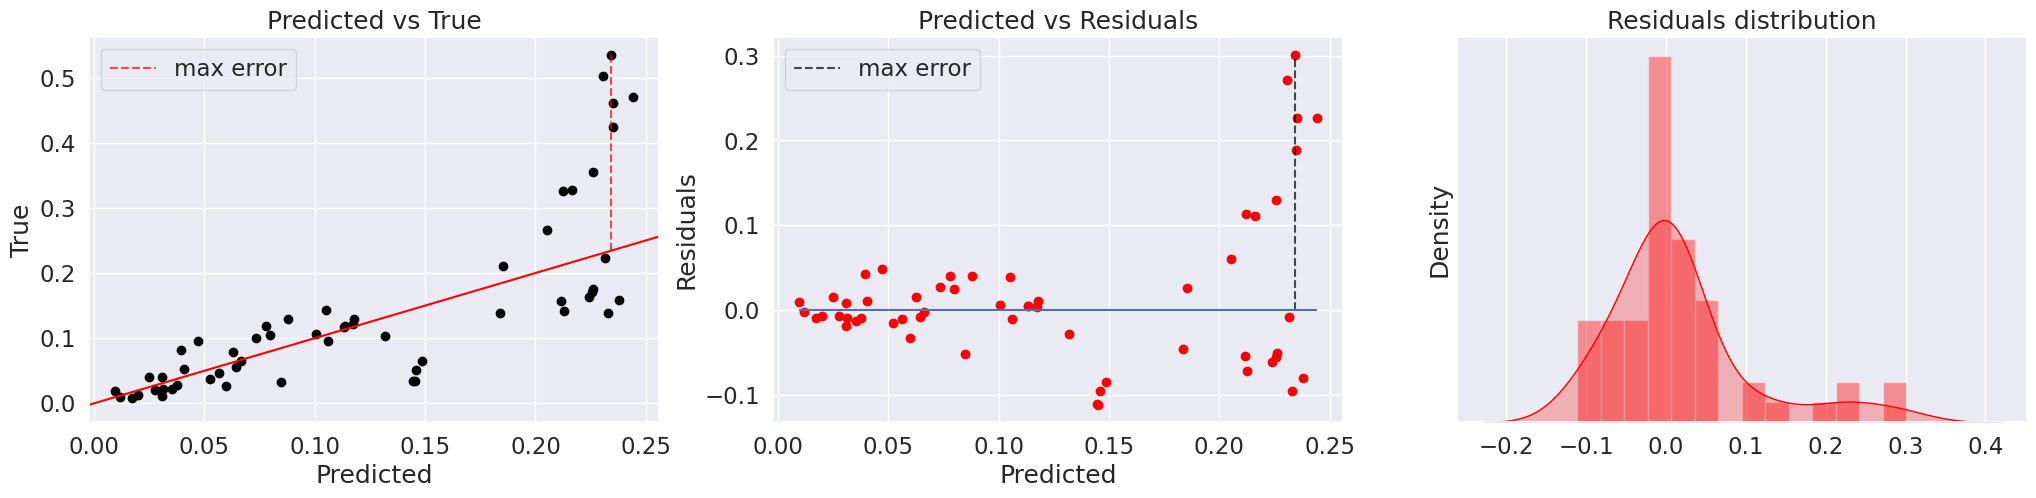

In [57]:

evaluate_regr_model(np.exp(np.array(y_test))/(1+np.exp(np.array(y_test))), np.exp(np.array(y_pred))/(1+np.exp(np.array(y_pred))))

Юзаем catboost для проверки значимости столбцов

In [58]:
df_upd

State NAICS  Term  NoEmp  CreateJob  RetainedJob  RevLineCr  LowDoc  \
480319    OH    72    36     12          0           12          0       0   
566137    AK   NaN   109      2          0            0          0       0   
878092    CA    54   240      1          1            0          0       0   
713956    CA    42     4      1          0            1          1       0   
26408     NJ    45    12      3          0            3          0       0   
...      ...   ...   ...    ...        ...          ...        ...     ...   
200550    IL    52    21      2          1            2          1       0   
133261    CA    45    56      2          1            2          0       0   
753102    MT   NaN    84     28          0            0          0       0   
214015    TX    44    84      2          0            2          1       0   
221880    ID    48    20      1          0            1          1       0   

       DisbursementDate  DisbursementGross  Default  DisbursementYr  \
480319       2011-04-06            25000.0        0            2011   
566137       1994-07-31           174000.0        0            1994   
878092       1997-02-12           165000.0        0            1997   
713956       2004-08-31            50000.0        1            2004   
26408        2005-06-30            60000.0        1            2005   
...                 ...                ...      ...             ...   
200550       2007-05-31           101441.0        1            2007   
133261       2006-09-30            23107.0        1            2006   
753102       1995-01-31           200000.0        0            1995   
214015       2006-11-30            58353.0        0            2006   
221880       2007-07-31            53074.0        1            2007   

        DisbursementMo  NewBusiness      Clusters  
480319               4            0  LowCreateJob  
566137               7            0  LowCreateJob  
878092               2            0  LowCreateJob  
713956               8            0  LowCreateJob  
26408                6            1  LowCreateJob  
...                ...          ...           ...  
200550               5            0  LowCreateJob  
133261               9            1  LowCreateJob  
753102               1            0  LowCreateJob  
214015              11            0  LowCreateJob  
221880               7            0  LowCreateJob  

[194430 rows x 15 columns]

In [59]:
from catboost import CatBoostClassifier, Pool


X_train, X_test, y_train, y_test = train_test_split(df_upd[['DisbursementGross', 'NoEmp', 'Term', 'CreateJob', 'RevLineCr', 'RetainedJob', 'LowDoc', 'DisbursementYr', 'NewBusiness']], df_upd["Default"], test_size=0.2, random_state=42 )

model = CatBoostClassifier()
# train the model
model.fit(X_train, y_train)
# make the prediction using the resulting model
preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)

f1_score(y_test, preds_class, average='macro'), model.feature_importances_

Learning rate set to 0.088891
0:	learn: 0.6180380	total: 85.8ms	remaining: 1m 25s
1:	learn: 0.5537901	total: 98.4ms	remaining: 49.1s
2:	learn: 0.5033351	total: 108ms	remaining: 35.8s
3:	learn: 0.4621780	total: 116ms	remaining: 28.8s
4:	learn: 0.4317713	total: 124ms	remaining: 24.6s
5:	learn: 0.4052712	total: 132ms	remaining: 21.8s
6:	learn: 0.3845995	total: 141ms	remaining: 20s
7:	learn: 0.3702830	total: 149ms	remaining: 18.5s
8:	learn: 0.3568596	total: 158ms	remaining: 17.4s
9:	learn: 0.3453900	total: 166ms	remaining: 16.4s
10:	learn: 0.3348486	total: 175ms	remaining: 15.8s
11:	learn: 0.3267485	total: 184ms	remaining: 15.1s
12:	learn: 0.3189412	total: 194ms	remaining: 14.7s
13:	learn: 0.3114910	total: 202ms	remaining: 14.2s
14:	learn: 0.3055594	total: 212ms	remaining: 13.9s
15:	learn: 0.3011090	total: 221ms	remaining: 13.6s
16:	learn: 0.2964778	total: 230ms	remaining: 13.3s
17:	learn: 0.2929471	total: 240ms	remaining: 13.1s
18:	learn: 0.2893118	total: 249ms	remaining: 12.8s
19:	learn:

(0.9351174894440939,
 array([ 5.0554208 ,  1.32988266, 67.73170325,  2.79069735,  4.43152633,
         2.24118645,  0.36072629, 15.31252605,  0.74633081]))

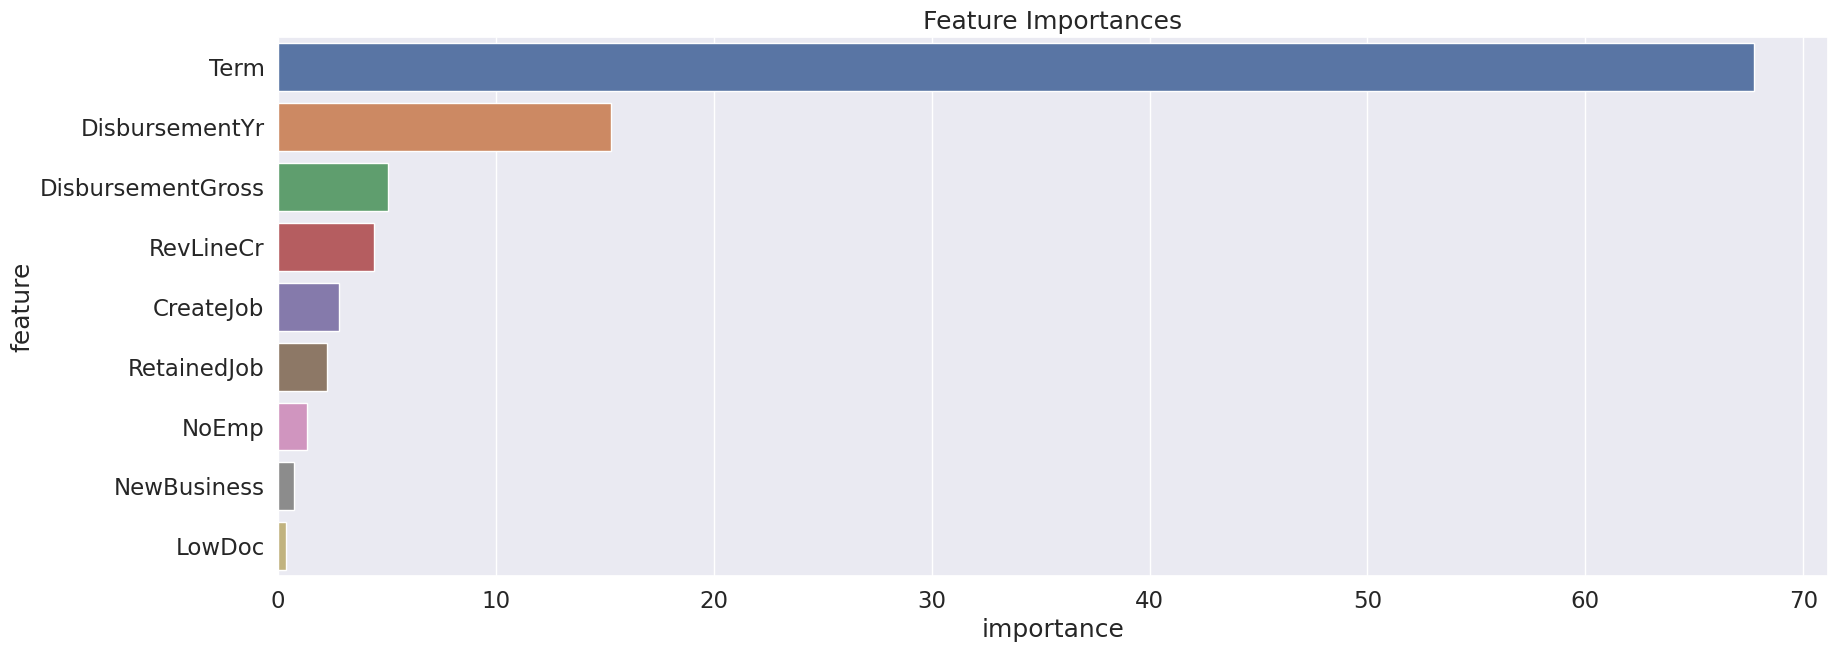

In [60]:
feature_importances = pd.DataFrame({'feature': ['DisbursementGross', 'NoEmp', 'Term', 'CreateJob', 'RevLineCr', 'RetainedJob', 'LowDoc', 'DisbursementYr', 'NewBusiness'],
                                    'importance': model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

DisbursementGross     NoEmp      Term  CreateJob  \
DisbursementGross           1.000000  0.067829  0.433421   0.022242   
NoEmp                       0.067829  1.000000  0.035797   0.007090   
Term                        0.433421  0.035797  1.000000   0.041677   
CreateJob                   0.022242  0.007090  0.041677   1.000000   
RevLineCr                   0.240302  0.031884  0.357941   0.023745   
Default                     0.121968  0.020536  0.328603   0.013190   

                   RevLineCr   Default  
DisbursementGross   0.240302  0.121968  
NoEmp               0.031884  0.020536  
Term                0.357941  0.328603  
CreateJob           0.023745  0.013190  
RevLineCr           1.000000  0.124868  
Default             0.124868  1.000000

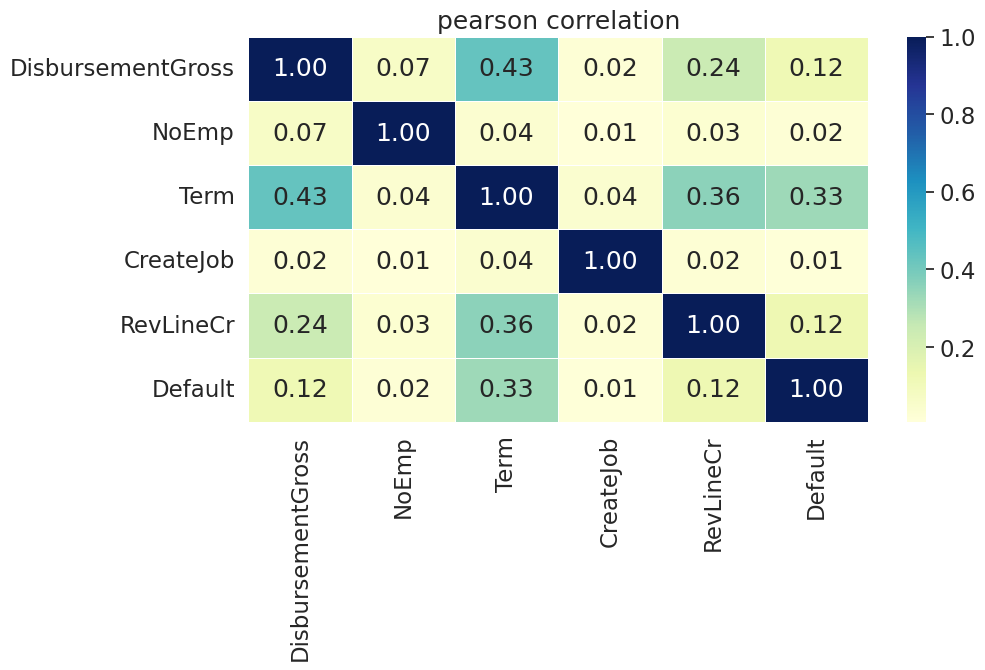

In [61]:
from utils import corr_matrix
corr_matrix(df[['DisbursementGross', 'NoEmp', 'Term', 'CreateJob', 'RevLineCr', 'Default']], negative=False, annotation=True)


DisbursementGross     NoEmp      Term  CreateJob  \
DisbursementGross           1.000000  0.067829  0.433421   0.022242   
NoEmp                       0.067829  1.000000  0.035797   0.007090   
Term                        0.433421  0.035797  1.000000   0.041677   
CreateJob                   0.022242  0.007090  0.041677   1.000000   
RevLineCr                   0.240302  0.031884  0.357941   0.023745   
RetainedJob                 0.021879  0.009146  0.038629   0.997170   
LowDoc                      0.176520  0.013225  0.034214   0.012836   
DisbursementYr              0.254883  0.051364  0.389512   0.068260   
NewBusiness                 0.066367  0.028332  0.038860   0.002419   
Default                     0.121968  0.020536  0.328603   0.013190   

                   RevLineCr  RetainedJob    LowDoc  DisbursementYr  \
DisbursementGross   0.240302     0.021879  0.176520        0.254883   
NoEmp               0.031884     0.009146  0.013225        0.051364   
Term                0.357941     0.038629  0.034214        0.389512   
CreateJob           0.023745     0.997170  0.012836        0.068260   
RevLineCr           1.000000     0.018727  0.261431        0.485471   
RetainedJob         0.018727     1.000000  0.015534        0.062839   
LowDoc              0.261431     0.015534  1.000000        0.262661   
DisbursementYr      0.485471     0.062839  0.262661        1.000000   
NewBusiness         0.106342     0.006500  0.114420        0.020121   
Default             0.124868     0.014167  0.132306        0.227107   

                   NewBusiness   Default  
DisbursementGross     0.066367  0.121968  
NoEmp                 0.028332  0.020536  
Term                  0.038860  0.328603  
CreateJob             0.002419  0.013190  
RevLineCr             0.106342  0.124868  
RetainedJob           0.006500  0.014167  
LowDoc                0.114420  0.132306  
DisbursementYr        0.020121  0.227107  
NewBusiness           1.000000  0.008240  
Default               0.008240  1.000000

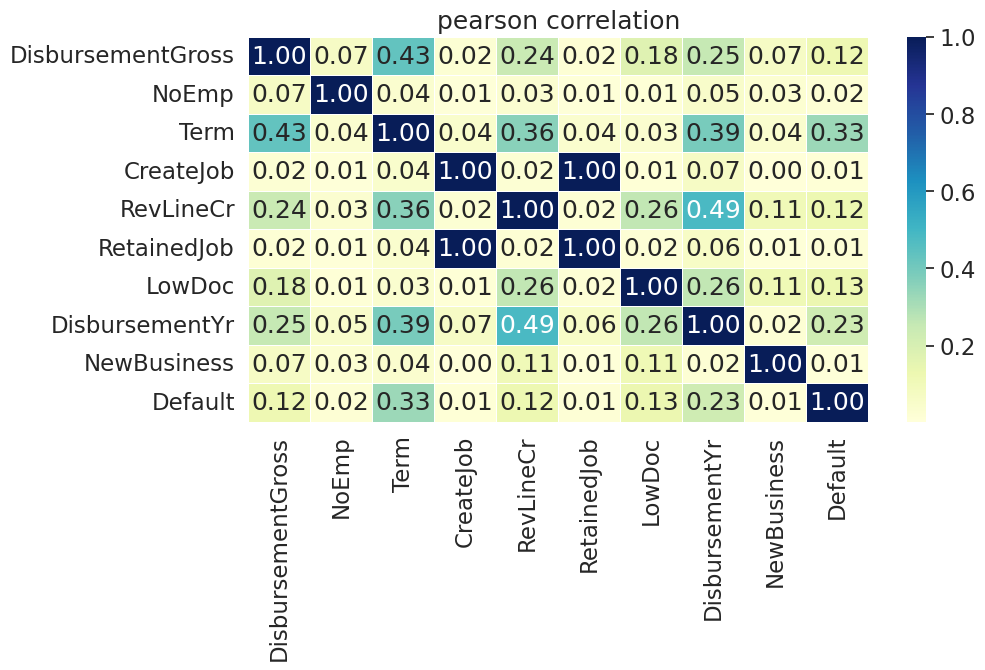

In [62]:
corr_matrix(df[['DisbursementGross', 'NoEmp', 'Term', 'CreateJob', 'RevLineCr', 'RetainedJob', 'LowDoc', 'DisbursementYr', 'NewBusiness', 'Default']], negative=False, annotation=True)

In [63]:
df_agg_M

DisbursementDate  Средний Term  Средний NoEmp  DisbursementYr  \
237          1990-01    131.789110      21.744413          1990.0   
238          1990-02    183.552846      19.268293          1990.0   
239          1990-03    177.253425      19.082192          1990.0   
240          1990-04    128.984592      16.271327          1990.0   
241          1990-05    147.299094      13.187311          1990.0   
..               ...           ...            ...             ...   
522          2013-10     72.830769      11.692308          2013.0   
523          2013-11     73.594595       5.405405          2013.0   
524          2013-12     63.585714       9.071429          2013.0   
525          2014-01     63.787879      14.909091          2014.0   
526          2014-02     63.250000       7.325000          2014.0   

     Средний DisbursementGross  Средний CreateJob  Средний RetainedJob  \
237              135441.937500           0.619260             0.469321   
238              166335.312500           7.195122             7.756098   
239              154888.468750           5.856164             5.938356   
240              136543.718750           0.417888             0.290492   
241              144547.390625           2.945619             2.848943   
..                         ...                ...                  ...   
522               92126.320312           3.369231             7.492308   
523               75329.093750           3.040541             4.418919   
524               93398.414062           2.457143             5.614286   
525               81725.625000           3.757576             7.818182   
526               56369.800781           2.425000             1.775000   

     Процент NewBusiness  Процент LowDoc  Процент RevLineCr  Процент Default  \
237             0.275498             0.0           0.000000         0.058106   
238             0.317073             0.0           0.000000         0.056911   
239             0.294521             0.0           0.000000         0.041096   
240             0.264186             0.0           0.000000         0.046223   
241             0.247734             0.0           0.000000         0.066465   
..                   ...             ...                ...              ...   
522             0.230769             0.0           0.461538         0.046154   
523             0.337838             0.0           0.486486         0.040541   
524             0.257143             0.0           0.571429         0.042857   
525             0.257576             0.0           0.484848         0.060606   
526             0.300000             0.0           0.525000         0.025000   

    DisbursementMonthlyDate                 Cluster  
237              1990-01-01  DisbursementYr >= 1990  
238              1990-02-01  DisbursementYr >= 1990  
239              1990-03-01  DisbursementYr >= 1990  
240              1990-04-01  DisbursementYr >= 1990  
241              1990-05-01  DisbursementYr >= 1990  
..                      ...                     ...  
522              2013-10-01  DisbursementYr >= 1990  
523              2013-11-01  DisbursementYr >= 1990  
524              2013-12-01  DisbursementYr >= 1990  
525              2014-01-01  DisbursementYr >= 1990  
526              2014-02-01  DisbursementYr >= 1990  

[276 rows x 13 columns]

Средний Term  Средний NoEmp  Средний CreateJob  \
Средний Term                   1.000000       0.843349           0.419727   
Средний NoEmp                  0.843349       1.000000           0.401247   
Средний CreateJob              0.419727       0.401247           1.000000   
Процент RevLineCr              0.784092       0.683766           0.160969   
Средний RetainedJob            0.034669       0.076608           0.812911   
Процент LowDoc                 0.242222       0.141407           0.181358   
DisbursementYr                 0.820735       0.685783           0.067199   
Средний DisbursementGross      0.905295       0.823039           0.356286   
Процент NewBusiness            0.334721       0.297173           0.169697   
Процент Default                0.595041       0.605061           0.187336   

                           Процент RevLineCr  Средний RetainedJob  \
Средний Term                        0.784092             0.034669   
Средний NoEmp                       0.683766             0.076608   
Средний CreateJob                   0.160969             0.812911   
Процент RevLineCr                   1.000000             0.239733   
Средний RetainedJob                 0.239733             1.000000   
Процент LowDoc                      0.549584             0.422043   
DisbursementYr                      0.751996             0.358387   
Средний DisbursementGross           0.722081             0.013733   
Процент NewBusiness                 0.135102             0.168655   
Процент Default                     0.613369             0.092242   

                           Процент LowDoc  DisbursementYr  \
Средний Term                     0.242222        0.820735   
Средний NoEmp                    0.141407        0.685783   
Средний CreateJob                0.181358        0.067199   
Процент RevLineCr                0.549584        0.751996   
Средний RetainedJob              0.422043        0.358387   
Процент LowDoc                   1.000000        0.404109   
DisbursementYr                   0.404109        1.000000   
Средний DisbursementGross        0.097081        0.765238   
Процент NewBusiness              0.383704        0.300503   
Процент Default                  0.332991        0.454348   

                           Средний DisbursementGross  Процент NewBusiness  \
Средний Term                                0.905295             0.334721   
Средний NoEmp                               0.823039             0.297173   
Средний CreateJob                           0.356286             0.169697   
Процент RevLineCr                           0.722081             0.135102   
Средний RetainedJob                         0.013733             0.168655   
Процент LowDoc                              0.097081             0.383704   
DisbursementYr                              0.765238             0.300503   
Средний DisbursementGross                   1.000000             0.344635   
Процент NewBusiness                         0.344635             1.000000   
Процент Default                             0.681728             0.196450   

                           Процент Default  
Средний Term                      0.595041  
Средний NoEmp                     0.605061  
Средний CreateJob                 0.187336  
Процент RevLineCr                 0.613369  
Средний RetainedJob               0.092242  
Процент LowDoc                    0.332991  
DisbursementYr                    0.454348  
Средний DisbursementGross         0.681728  
Процент NewBusiness               0.196450  
Процент Default                   1.000000

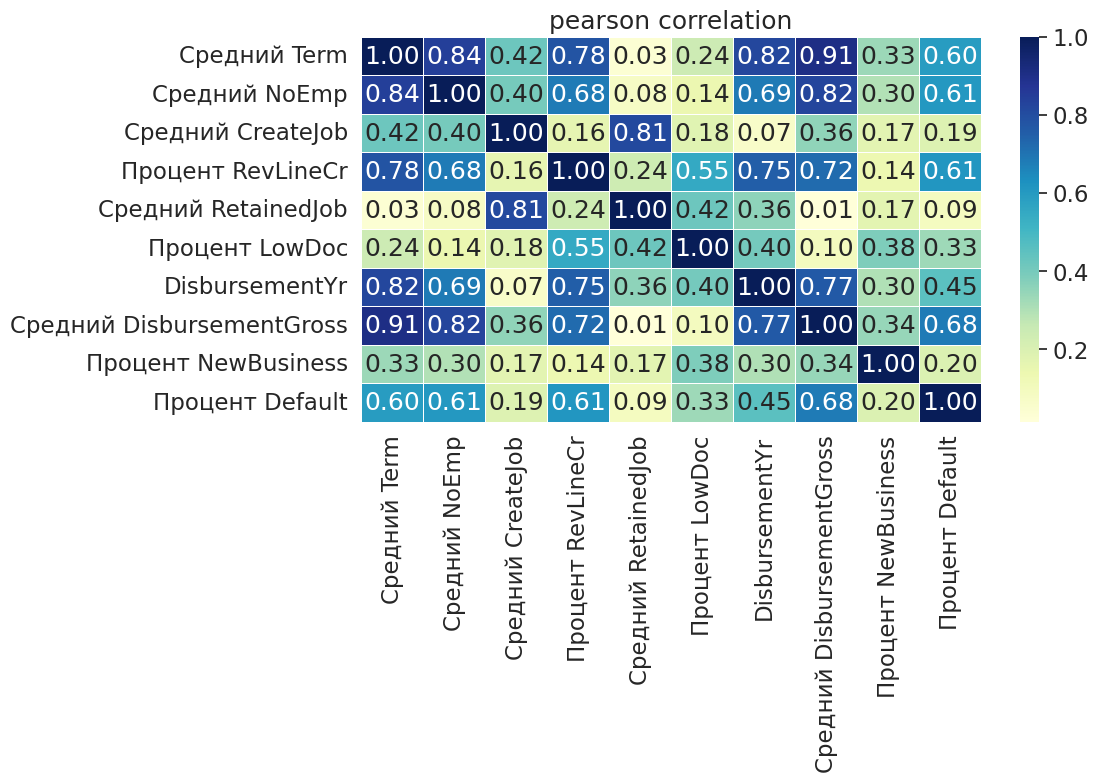

In [64]:
corr_matrix(df_agg_M[['Средний Term', 'Средний NoEmp', 'Средний CreateJob', 'Процент RevLineCr', 'Средний RetainedJob', 'Процент LowDoc', 'DisbursementYr', 'Средний DisbursementGross',  'Процент NewBusiness','Процент Default']], negative=False, annotation=True)

In [65]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
k = poly.fit_transform(np.array([[1,2], [2, 1]]))
# X_train, X_test, y_train, y_test = train_test_split(k, df_upd["Default"], test_size=0.2, random_state=42 )
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# logisticRegr = LogisticRegression()
# logisticRegr.fit(X_train, y_train)
# predictions = logisticRegr.predict(X_test)

# logisticRegr.score(X_test, y_test), logisticRegr.coef_
k

array([[1., 1., 2., 1., 2., 4.],
       [1., 2., 1., 4., 2., 1.]])